# Experiment

## Perequisites

Extract the data to `./metrics`

## Preparations

Import necessary libraries

Idées de mesures:

- distribution des fonctions
- politique basique edge first ou quoi
- temps de deploiement vs nombre de noeuds dans le Fog vs taille du réseau
- temps de deploiement vs nombre de fonctions vs taille du réseau
- la mémoire et le cpu au niveau du noeud fog

graohes des localités : courbe qui montre combien de fonctions se répartissent sur l'edge et sur le cloud
faire varier le nombre de noeuds

Changer le nombre de fonctions que l'on déploi = saturation (x nbre de fonction)
Regarder l'évolution des temps de réponses / des violations de temps de deadline

Regarder si on satisfait les deadlines et si c'est scalable

Comparer en terme de prix = pas relevant
Définir une fonction d'utilité au niveau des enchères, par rapport au temps d'exécution




In [87]:
METRICS_PATH <- "metrics-arks"
METRICS_ARKS <- c(
#    "metrics_valuation_rates_bigger_1-auction_valuation_rates_no-telemetry_2023-05-12-10-45.tar.xz",
   "metrics_valuation_rates_bigger_1-auction_valuation_resources_no-telemetry_2023-05-16-12-40.tar.xz"
) # looks at "./*"

METRICS_GROUP <- c(
    # "auction_rate",
    "auction_res"
)

METRICS_GROUP_GROUP <- c(
# "v",
"v"    
)
length(METRICS_ARKS)
length(METRICS_GROUP)
length(METRICS_GROUP_GROUP)
stopifnot(length(METRICS_ARKS) == length(METRICS_GROUP))
stopifnot(length(METRICS_ARKS) == length(METRICS_GROUP_GROUP))

[1] 1

[1] 1

[1] 1

In [88]:
# packages_to_have <- c('cowplot', 'reticulate', 'tidyverse', 'igraph', 'r2r', 'formattable', 'stringr', 'viridis', 'geomtextpath')

# dir.create(Sys.getenv("R_LIBS_USER"), recursive = TRUE)  # create personal library
# .libPaths(Sys.getenv("R_LIBS_USER"))  # add to the path

# packages = installed.packages()
# packages = packages[, "Package"]

# if (FALSE %in% (packages_to_have %in% packages)){
#     install.packages(packages_to_have)
# }

# To call python from R
library(archive)
library(dplyr)
library(reticulate)
library(tidyverse)
library(igraph)
library(r2r)
library(formattable)
library(stringr)
library(viridis)
library(geomtextpath)
library(cowplot)
library(data.table)
library(scales)
library(vroom)
library(zoo)
library(ggdist)
library(gghighlight)
library(ggrepel)
library(ggbreak)
library(grid)
library(lemon)
library(ggprism)
library(ggh4x)
theme_set(theme_prism())


In [89]:
correct_names <- function(x){
    return(
        x %>%
            mutate(metric_group_rich = case_when(
                metric_group == "auction" ~ "\\textit{Auction (ours)}",
                metric_group == "edge_ward" ~ "Edge ward",
                metric_group == "edge_ward_furthest" ~ "Edge ward furthest",
                metric_group == "edge_first" ~ "Edge first",
                metric_group == "edge_furthest" ~ "Edge furthest",
                TRUE ~ metric_group
          )) %>%
        mutate(metric_group = factor(metric_group, levels = c("edge_ward", "edge_ward_furthest", "edge_first", "edge_furthest", "auction"), ordered = TRUE)) %>%
        # mutate(metric_group_rich = factor(metric_group_rich, levels = unique(metric_group), ordered = TRUE)) %>%
        rename(`Placement method` = metric_group_rich)
        # mutate(`Placement method` = factor(`Placement method`, levels = factor(unique(metric_group), ordered = TRUE), ordered = TRUE)) 
    )
}

Then, the dependencies

Load the the Python `integration.py` script to use its variable in R

In [90]:
# use_virtualenv('.venv/', required = TRUE)
# Always throws an error because it is a CLI tool; it is not made to be loaded in R
try(source_python("definitions.py"))


The graph of the network

In [91]:
raw <- py$ADJACENCY

adjancy_transform <- function(x) {
  ret <- matrix(0, nrow = length(x), ncol = length(x))
  rownames(ret) <- c(sort(names(x)))
  colnames(ret) <- c(sort(names(x)))
  for (ii in seq_along(x)) {
    for (jj in seq_along(x[[ii]])) {
      ret[names(x)[[ii]], x[[ii]][[jj]][[1]]] <- strtoi(x[[ii]][[jj]][[2]])
    }
  }
  return(ret)
}

graph_matrix <- adjancy_transform(raw)


In [92]:
# stack(py$LEVELS)
# node_levels <- stack(py$LEVELS) %>%
# node_levels <- stack(data.frame(unlist(py$LEVELS))) %>%
#     mutate(name = ind, level = values) %>%
#     select(-c(ind)) %>%
#     mutate(level = case_when(
#         level == 0 ~ "Cloud",
#         level == max(level) - 1 ~ "Edge+1",
#         level == max(level) ~ "Edge",
#         TRUE ~ paste("Cloud", as.character(level), sep = "+")
#     )) %>%
#     # add_row(values = 0, name="marketplace", level="Cloud") %>%
#     mutate(level2 = factor(as.character(level), levels = levels(factor(values, ordered = TRUE)), ordered = TRUE))
#     # mutate(level2 = factor(as.character(level), levels = levels(as.numeric(values)), ordered = TRUE)) %>%
#     # mutate(level = factor(level, levels=level[order(unique(values))])) %>%
#     {.}
py_levels <- data.frame(values = unlist(py$LEVELS))

node_levels <- py_levels %>%
  mutate(name = rownames(py_levels),
         level = case_when(
           values == 0 ~ "Cloud",
           values == max(values) - 1 ~ "Edge+1",
           values == max(values) ~ "Edge",
           TRUE ~ paste("Cloud", as.character(values), sep = "+")
         )) %>%
  # add_row(values = 0, name = "marketplace", level = "Cloud") %>%
  mutate(level = factor(level, levels = unique(level), ordered = TRUE))

Load the names of the node and their correspondance in their IP on the virtual network

In [93]:
load_csv <- function(filename) {
    all_data <- purrr::map_df(METRICS_ARKS, ~ mutate(vroom(archive_read(paste(METRICS_PATH, .x, sep = "/"), file = filename), col_names = TRUE, delim = "\t", .name_repair="unique") %>% distinct(),
        folder = tools::file_path_sans_ext(tools::file_path_sans_ext(.x)),
        metric_group = METRICS_GROUP[which(METRICS_ARKS == .x)],
        metric_group_group = METRICS_GROUP_GROUP[which(METRICS_ARKS == .x)]
    ))
    # print(head(all_data))
    return(all_data)
}


In [94]:
names_raw <- load_csv("names.csv")
addresses <- stringr::str_match(names_raw$instance, "(.+):([0-9]+)")
names_raw$instance <- addresses[, 2]
names_raw <- names_raw %>% filter(name != "marketplace")
missing <- data.frame(instance = names_raw$name, n = 0)

# names_raw

Rows: 9 Columns: 2
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): instance, name

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [95]:
fig <- function(width, heigth) {
  options(repr.plot.width = width, repr.plot.height = heigth)
}

fig(20, 20)

adjust_timestamps <- function(x) {
  return(
    x %>%
      group_by(folder) %>%
      mutate(timestamp = timestamp - min(timestamp)) %>%
      ungroup()
  )
}

prepare <- function(x) {
  addresses <- stringr::str_match(x$instance, "(.+):([0-9]+)")
  x$instance <- addresses[, 2]

  return(
    x %>%
      inner_join(names_raw %>% mutate(instance_name = name) %>% select(-name), c("instance", "folder", "metric_group", "metric_group_group")) %>%
      mutate(instance = instance_name) %>%
      select(-instance_name) %>%
      mutate(timestamp = as.POSIXct(as.numeric(as.character(timestamp)), origin = "1970-01-01")) %>%
      mutate(value = as.numeric(value)) %>%
      adjust_timestamps() %>%
      # merge(missing, all = TRUE) %>%
      # arrange(instance) %>%
      {
        .
      }
  )
}

extract_function_name_info <- function(x) {
  # The first element is the input string
  info <- stringr::str_match(x$function_name, "(.+)-([0-9]+)-([0-9]+)-([0-9]+)-([0-9]+)-([a-z]+)-([a-z]+)-([0-9]+)-([0-9]+)")
  return(
    x %>%
      ungroup() %>%
      mutate(docker_fn_name = info %>% .[, 2]) %>%
      mutate(function_index = info %>% .[, 3]) %>%
      mutate(latency = info %>% .[, 4]) %>%
      mutate(cpu = info %>% .[, 5]) %>%
      mutate(mem = info %>% .[, 6]) %>%
      mutate(load_type = info %>% .[, 7]) %>%
      mutate(latency_type = info %>% .[, 8]) %>%
      mutate(nb_fn_low_interval_low_latency = info %>% .[, 9]) %>%
      mutate(nb_fn_high_interval_low_latency = info %>% .[, 10]) %>%
      mutate(latency_type = case_when(
        latency_type == "low" ~ "Low latency",
        latency_type == "high" ~ "High latency"
      )) %>%
      mutate(load_type = case_when(
        load_type == "low" ~ "High load",
        load_type == "high" ~ "Low load"
      ))
  )
}


## Data processing

Check what nodes we have values for (usually the ones who have submitted bids and etc.):
- Green is ok
- Red is a node that was not present in the data

NULL

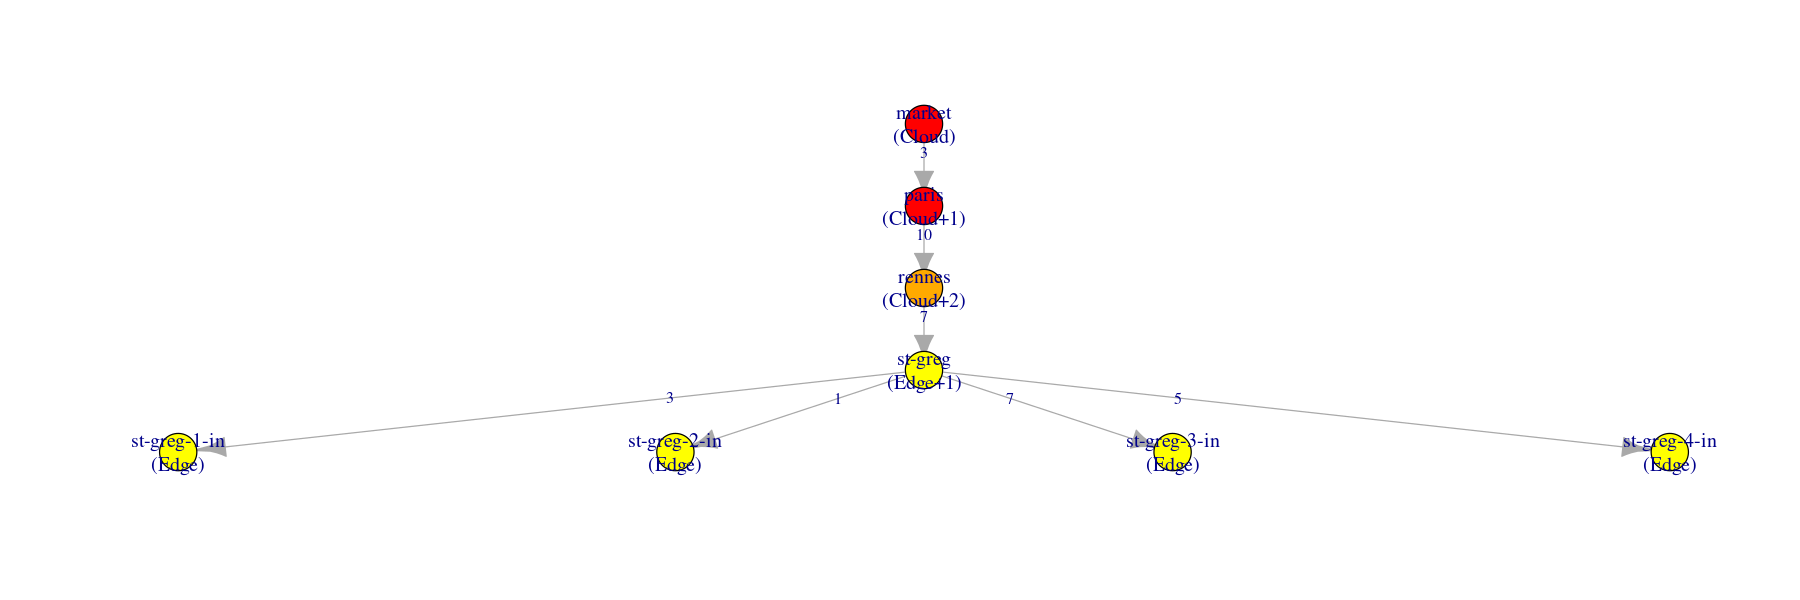

In [96]:
net_connected <- graph_from_adjacency_matrix(as.matrix(graph_matrix), weighted = TRUE)
colors <- heat.colors(length(unique(node_levels$level)))
colors <- c('#FF0000', '#FF0000', '#FFAA00', '#FFFF00', '#FFFF00')
node_level_map <- setNames(node_levels$level, node_levels$name)
color_map <- setNames(colors, unique(node_levels$level))
node_names <- merge(data.frame(name = V(net_connected)$name, stringsAsFactors = FALSE), node_levels, by.x = "name", by.y = "name")
node_names$name <- paste(node_names$name, paste("(", node_names$level, ")", sep = ""), sep = "\n")

V(net_connected)$color <- color_map[node_level_map[V(net_connected)$name]]
V(net_connected)$name <- node_names$name
# V(net_connected)$name <- ""
fig(15, 5)
coords = layout_as_tree(net_connected)
# spacingfactor <- 40
# coords[, 1] <- coords[, 1] * spacingfactor
# coords[, 2] <- coords[, 2] * spacingfactor
node_graph <- plot(net_connected, layout = coords,asp=0.22, margin=-0, vertex.label=E(net_connected)$name, edge.label = E(net_connected)$weight, edge.width = 1, vertex.size = 5,vertex.size2 = 3, vertex.label.cex = 1, vertex.dist = 20, edge.arrow.size = 0.5, edge.label.cex = 0.8, edge.label.dist = 1.5)
node_graph
fig(10, 10)


## Distribution of the functions in the network

Latency of the nodes from their rolling average

> It is actually the double of the set latency because first the TCP connection is established and then the data flows. So those are actually: src -> dest and then src -> dest, so counting twice as long as the actual network latency.

In [97]:
latency <- load_csv("fog_node_neighbors_latency_rolling_avg.csv") %>%
  prepare() %>%
  inner_join(names_raw %>% mutate(instance_to = instance) %>% mutate(destination_name = name) %>% select(-c(instance, name)), c("instance_to", "folder", "metric_group")) 
latency_instants <- load_csv("fog_node_neighbors_latency.csv") %>%
  prepare() %>%
  inner_join(names_raw %>% mutate(instance_to = instance) %>% mutate(destination_name = name) %>% select(-c(instance, name)), c("instance_to", "folder", "metric_group")) 
latency_median <- load_csv("fog_node_neighbors_latency_rolling_median.csv") %>%
  prepare() %>%
  inner_join(names_raw %>% mutate(instance_to = instance) %>% mutate(destination_name = name) %>% select(-c(instance, name)), c("instance_to", "folder", "metric_group")) 
latency_median_interquantile_range <- load_csv("fog_node_neighbors_latency_rolling_interquartile_range.csv") %>%
  prepare() %>%
  inner_join(names_raw %>% mutate(instance_to = instance) %>% mutate(destination_name = name) %>% select(-c(instance, name)), c("instance_to", "folder", "metric_group")) 

latency_goals <- latency %>%
  ungroup() %>% 
  select(destination_name, instance) %>% 
  distinct() %>% 
  rowwise() %>%
  mutate(goal = max(graph_matrix[instance, destination_name], graph_matrix[destination_name, instance]))
  # mutate(goal = graph_matrix[destination_name, instance])

latency <- latency %>% 
  select(destination_name, value, instance, timestamp, folder, metric_group) %>%
  inner_join(latency_goals, by = c("instance", "destination_name")) %>%
  mutate(value = value) %>%
  mutate(diff = value - goal)

latency_instants <- latency_instants %>% 
  select(destination_name, value, instance, timestamp, folder, metric_group) %>%
  inner_join(latency_goals, by = c("instance", "destination_name")) %>%
  mutate(value = 1000*value) %>%
  mutate(diff = value - goal)

latency_median <- latency_median %>% 
  select(destination_name, value, instance, timestamp, folder, metric_group) %>%
  inner_join(latency_goals, by = c("instance", "destination_name")) %>%
  mutate(value = value) %>%
  mutate(diff = value - goal)
# latency_goals
# head(latency_goals %>% filter(destination_name == "st-greg"))
# head(latency %>% filter(destination_name == "st-greg"))

Rows: 2595 Columns: 6
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (4): name, instance, instance_to, job
dbl (2): timestamp, value

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2763 Columns: 6
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (4): name, instance, instance_to, job
dbl (2): timestamp, value

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2595 Columns: 6
── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────

Joining, by = c("destination_name", "value", "instance", "timestamp", "folder", "metric_group", "goal", "diff", "type")
Joining, by = c("destination_name", "value", "instance", "timestamp", "folder", "metric_group", "goal", "diff", "type")
`summarise()` has grouped output by 'instance', 'destination_name', 'folder', 'metric_group', 'type'. You can override using the `.groups` argument.
Don't know how to automatically pick scale for object of type difftime. Defaulting to continuous.



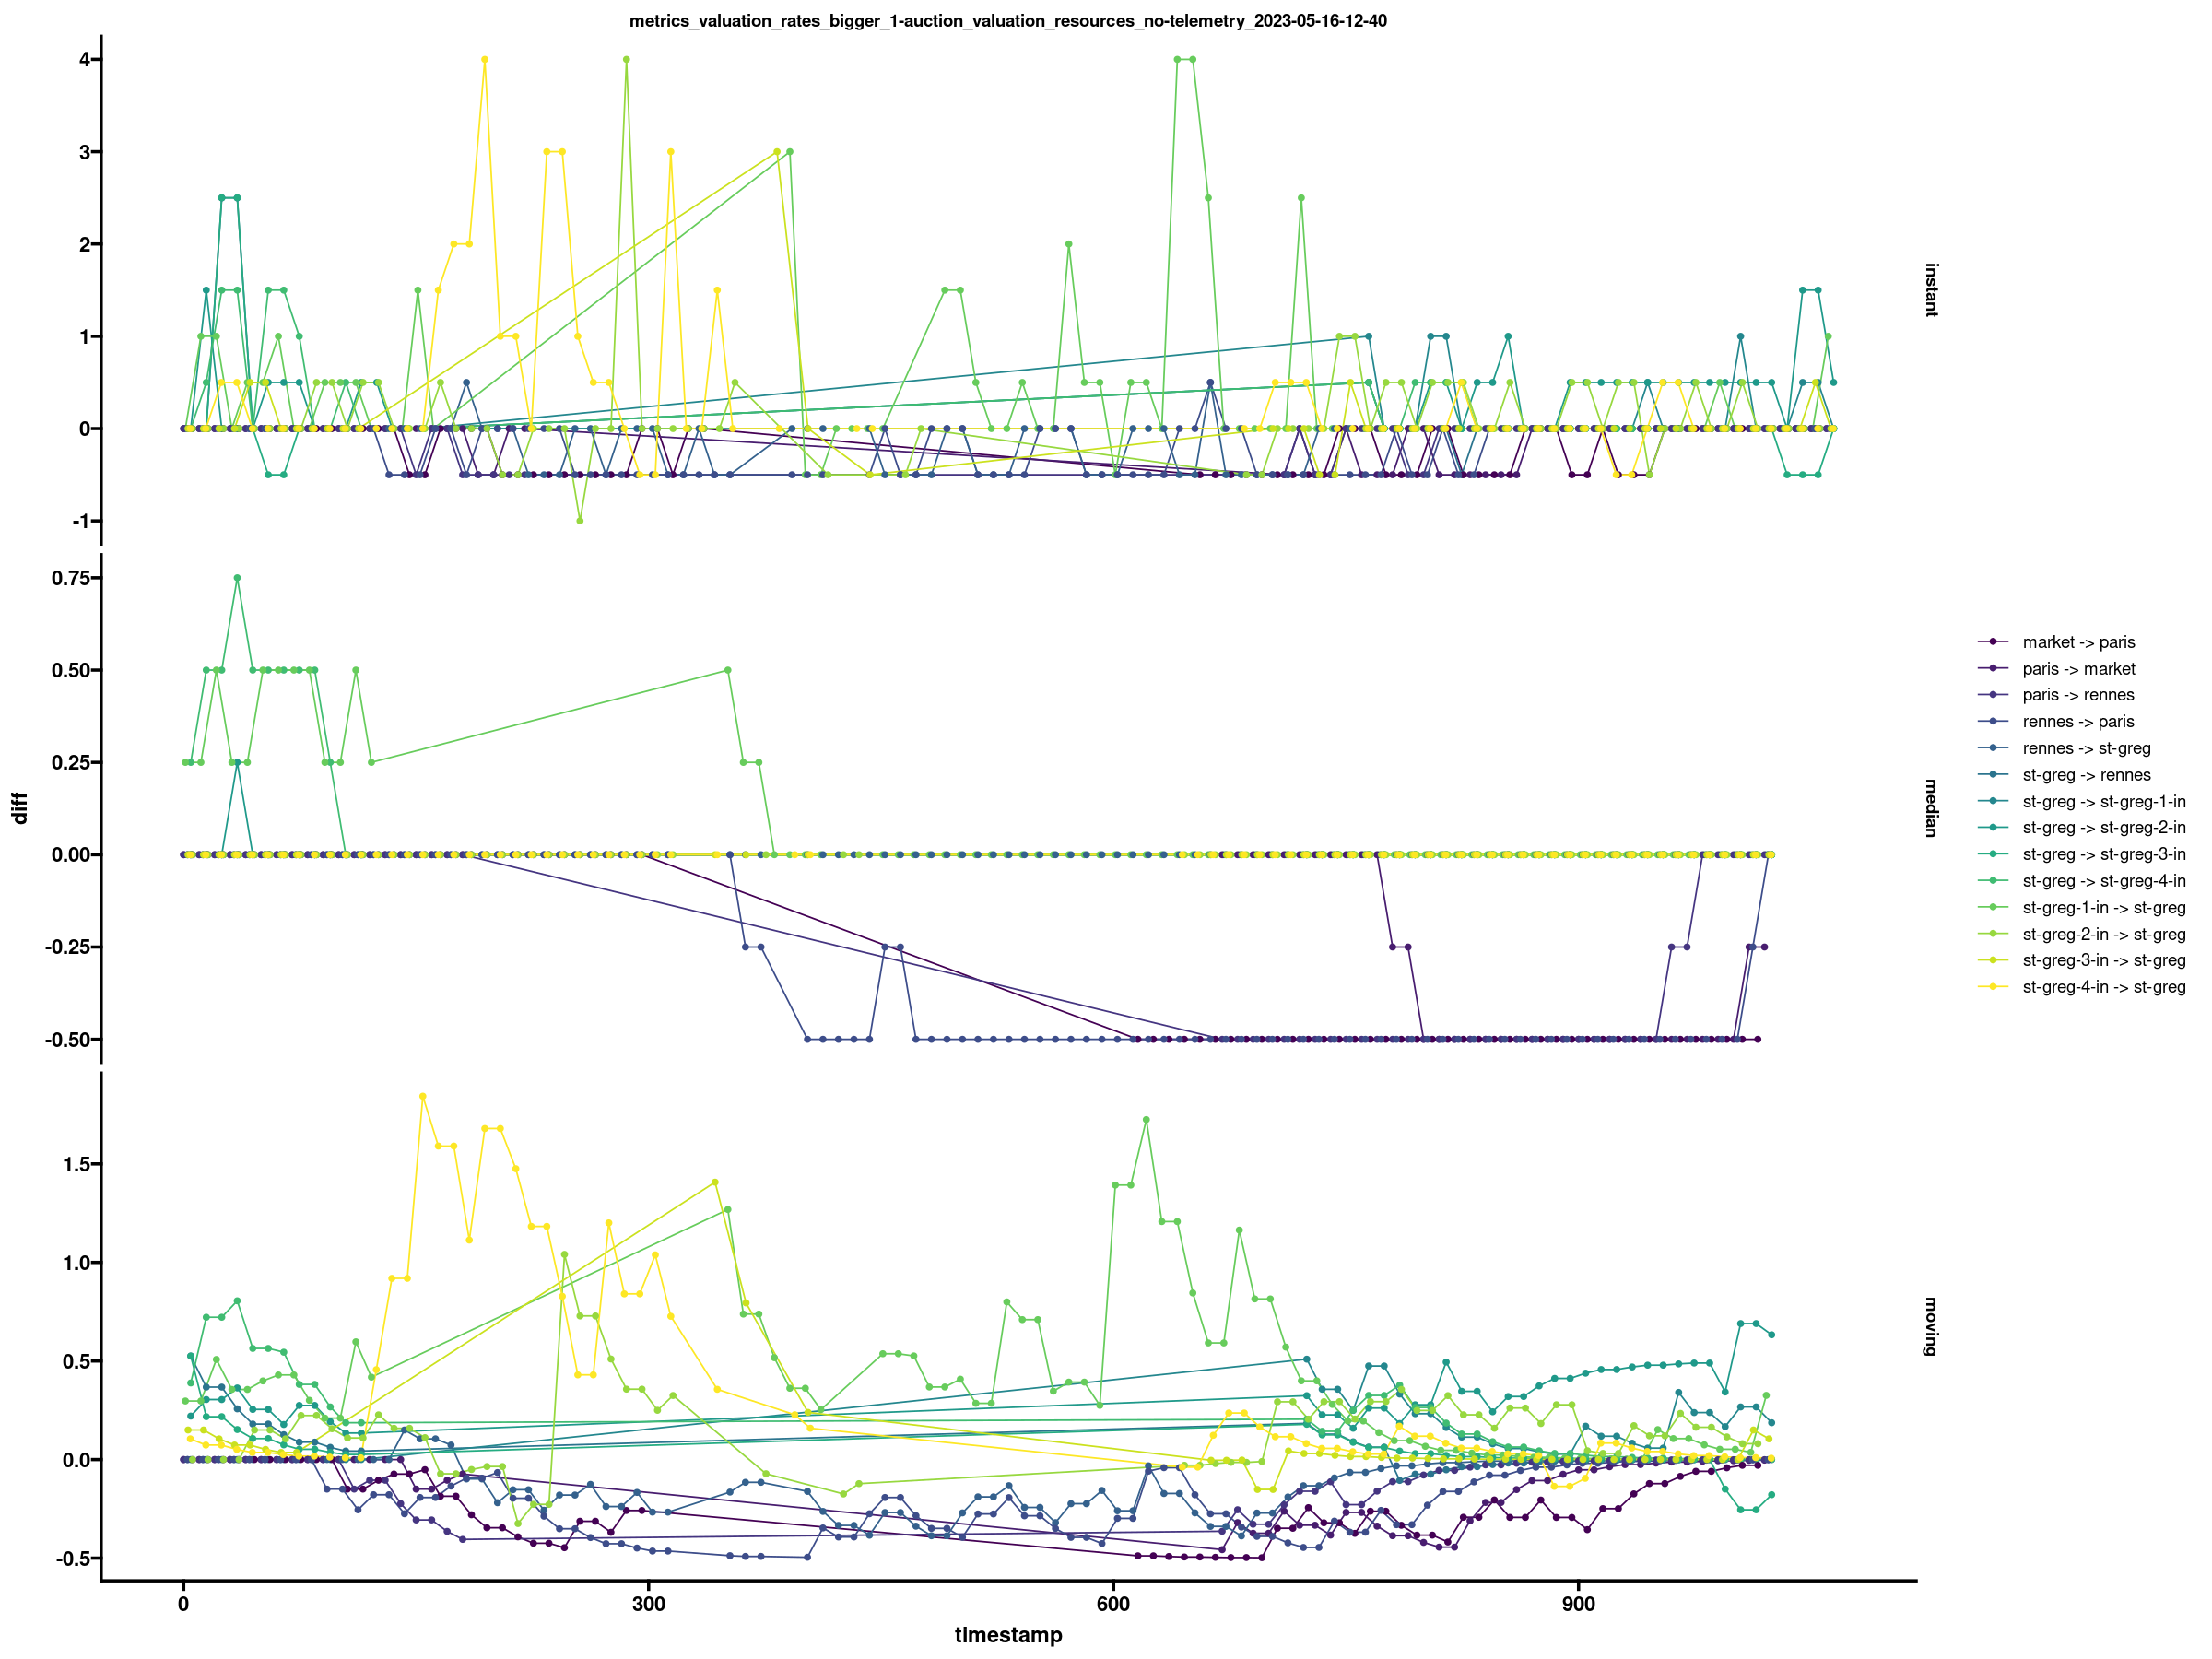

In [98]:
latency_data_raw <- latency %>%
  mutate(type = "moving") %>%
  full_join(latency_instants %>% mutate(type = "instant")) %>%
  full_join(latency_median %>% mutate(type = "median")) %>%
  full_join(latency_median_interquantile_range %>% mutate(type = "interquantile", diff = value))
  

latency_data <- latency_data_raw %>%
  # group_by(instance, folder, metric_group) %>%
  # arrange(timestamp, .by_group = TRUE) %>%
  # summarise(auc = sum(diff(timestamp) * rollmean(value, 2))) %>%
  group_by(instance, destination_name, folder, metric_group, type) %>%
  summarise(
    quantile = scales::percent(c(0.01, 0.25, 0.5, 0.75, 0.95, 0.99)),
    diff = quantile(diff, c(0.01, 0.25, 0.5, 0.75, 0.95, 0.99))
  ) %>%
  # pivot_longer(cols = -c("instance", "instance_to", "folder"), names_to = c("quantile")) %>%
  {
    .
  }

# head(latency)
fig(20, 15)

latency_data_raw %>%
  group_by(folder, instance, destination_name) %>%
  # filter(any(abs(diff) > 3)) %>%
  ggplot(
    aes(
      x = timestamp,
      # color = factor(str_replace(interaction(instance, destination_name), "\\.", " -> "), ordered = TRUE),
      # group = type,
      color = factor(str_replace(interaction(instance, destination_name), "\\.", " -> "), ordered = TRUE),
      y = diff,
    )
  ) +
  geom_line() +
  geom_point() +
  facet_grid(cols = vars(folder), rows = vars(type), scale = "free") +
  theme(
    # legend.position = "none"
  )

# fig(20, 25)
# latency_data %>%
#   ggplot(
#     aes(
#       y = factor(str_replace(interaction(instance, destination_name), "\\.", " -> "), ordered = TRUE),
#       x = quantile,
#       fill = diff,
#     )
#   ) +
#   geom_raster() +
#   # geom_text(aes(label=round(diff)), color = "white", alpha=.7, size = 3) +
#   scale_fill_viridis_c(option = "inferno") + # trans = 'pseudo_log',
#   # scale_fill_gradient2(low = "black", high = "white") +
#   facet_grid(rows = vars(folder), cols = vars(type), scale = "free") +
#   labs(
#     x = "Quantiles",
#     y = "Links (node <U+2192> destination)",
#     title = "Observed latencies",
#     subtitle = "Perceived by the node",
#     fill = "Latency (ms)",
#   )


## Bids

In [99]:
functions <- load_csv("market_refused_functions.csv") %>%
    prepare() %>%
    extract_function_name_info() %>%
    select(instance, sla_id, folder, metric_group, metric_group_group, load_type, latency_type) %>%
    distinct() %>%
    mutate(status = "provisioned") %>%
    group_by(instance, folder, metric_group, metric_group_group, load_type, latency_type, status) %>%
    summarise(n = n())

functions <- load_csv("market_provisioned_functions.csv") %>%
    prepare() %>%
    extract_function_name_info() %>%
    select(instance, sla_id, folder, metric_group, metric_group_group, load_type, latency_type) %>%
    distinct() %>%
    mutate(status = "refused") %>%
    group_by(instance, folder, metric_group, metric_group_group, load_type, latency_type, status) %>%
    summarise(n = n()) %>%
    full_join(functions, by = c("instance", "folder", "metric_group", "metric_group_group", "load_type", "latency_type", "status", "n")) %>%
    {
        .
    }

# functions


Rows: 22188 Columns: 7
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (5): name, function_name, instance, job, sla_id
dbl (2): timestamp, value

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
`summarise()` has grouped output by 'instance', 'folder', 'metric_group', 'metric_group_group', 'load_type', 'latency_type'. You can override using the `.groups`
argument.
Rows: 70632 Columns: 7
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (5): name, function_name, instance, job, sla_id
dbl (2): timestamp, value

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types o

`summarise()` has grouped output by 'folder', 'instance', 'metric_group', 'metric_group_group', 'load_type'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'folder', 'status', 'metric_group', 'metric_group_group', 'load_type'. You can override using the `.groups` argument.


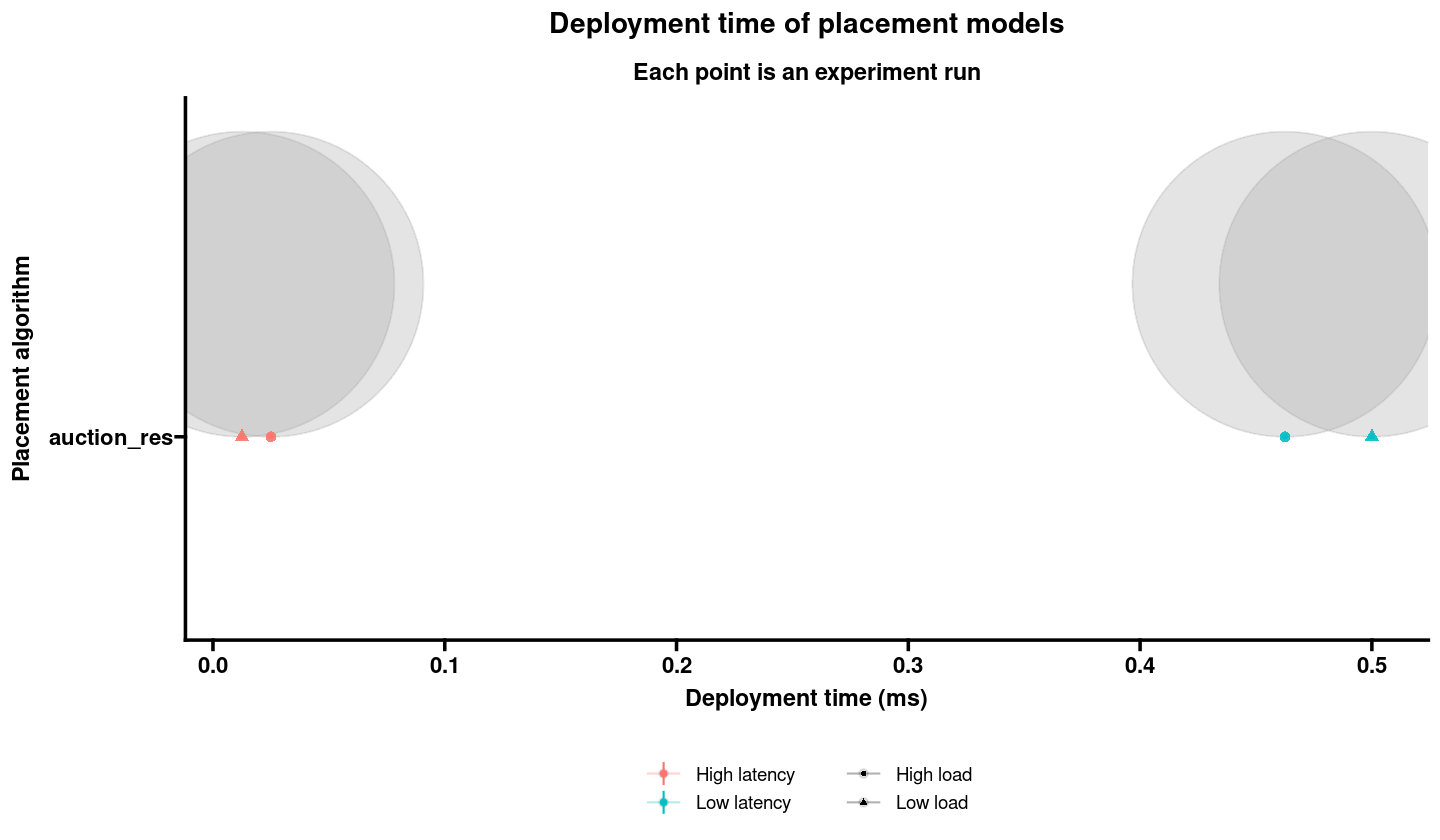

In [100]:
total <- functions %>%
    group_by(folder, instance, metric_group, metric_group_group, load_type, latency_type) %>%
    summarise(total = sum(n))
functions_total <- functions %>%
    inner_join(total, by = c("instance", "folder", "metric_group", "metric_group_group", "load_type", "latency_type")) %>%
    # inner_join(node_levels %>% mutate(instance = name) %>% select(-name), by = c("instance")) %>%
    group_by(folder, status, metric_group, metric_group_group, load_type, latency_type) %>%
    summarise(total = sum(total), n = sum(n)) %>%
    mutate(ratio = n / total) %>%
    {
        .
    }

fig(12, 7)

# functions_total %>% select(metric_group) %>% 
functions_total %>%
    # ungroup() %>%
    filter(status == "provisioned") %>%
    correct_names() %>%
    ggplot(
        aes(
            y = `Placement method`,
            x = ratio,
            # color = factor(str_replace(interaction(load_type, latency_type), "\\.", ", ")),
            # shape = factor(str_replace(interaction(load_type, latency_type), "\\.", ", "))
            color = latency_type,
            shape = load_type,
        )
    ) +
    # geom_point()  +
    stat_dotsinterval() +
    # stat_dotsinterval(position = "dodge", point_interval = mode_hdci, point_alpha = 1) +
    gghighlight(metric_group == "auction", unhighlighted_params = list(point_alpha = 0.9, colour = NULL, fill = NULL, alpha = 0.3), label_params = list(linewidth = 10), calculate_per_facet = TRUE) +
    # facet_grid(cols = vars(average_type), scales = "free") +
    labs(
        x = "Deployment time (ms)",
        y = "Placement algorithm",
        title = "Deployment time of placement models",
        subtitle = "Each point is an experiment run",
        color = "Function type",
        shape = "Function type",
    ) +
    theme(
        legend.position = "bottom",
        legend.direction = "vertical",
    )


In [101]:
bids_raw <- load_csv("fog_node_bids.csv") %>% prepare()

Rows: 183930 Columns: 8
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (6): name, bid_id, function_name, instance, job, sla_id
dbl (2): timestamp, value

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


`summarise()` has grouped output by 'sla_id', 'folder', 'metric_group', 'metric_group_group', 'latency_type'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'folder', 'metric_group', 'metric_group_group'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'folder', 'metric_group', 'metric_group_group'. You can override using the `.groups` argument.
Warning message:
“Tried to calculate with group_by(), but the calculation failed.
Falling back to ungrouped filter operation...”


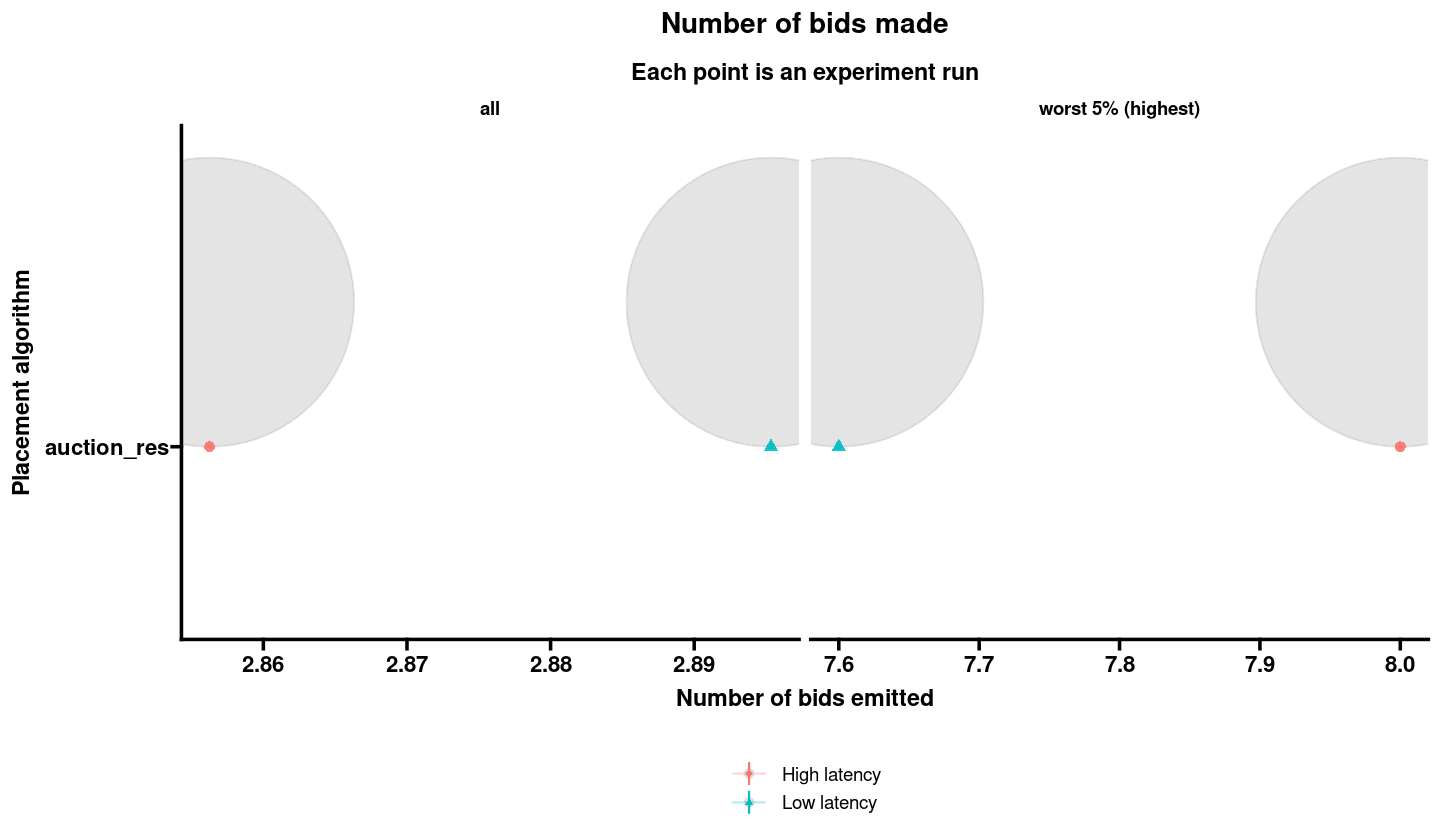

In [102]:
bids_function <- bids_raw %>%
  # inner_join(node_levels %>% mutate(instance = name) %>% select(-name), by = c("instance")) %>%
  select(instance, folder, metric_group, metric_group_group, function_name, sla_id, bid_id) %>%
  ungroup() %>%
  distinct() %>%
  extract_function_name_info() %>%
  group_by(sla_id, folder, metric_group, metric_group_group, latency_type, load_type) %>%
  summarise(n = n()) %>%
  {
    .
  }


top_1_percent <- bids_function %>%
  group_by(folder, metric_group, metric_group_group, latency_type) %>%
  arrange(desc(n), .by_group = T) %>%
  mutate(rank = row_number()) %>%
  filter(rank <= ceiling(n() * 0.05)) %>%
  group_by(folder, metric_group, metric_group_group, latency_type) %>%
  summarize(n_1_percent = mean(n))

bids_function <- bids_function %>%
  group_by(folder, metric_group, metric_group_group, latency_type) %>%
  summarize(n = mean(n)) %>%
  inner_join(top_1_percent, by = c("folder", "metric_group", "latency_type")) %>%
  gather(key = "n_type", value = "n", n, n_1_percent) %>%
  mutate(n_type = case_when(
    n_type == "n" ~ "all",
    n_type == "n_1_percent" ~ "worst 5% (highest)",
  )) %>%
  {
    .
  }


# bids_function
# fig(12, 5)
# bids_function_graph <- bids_function %>%
#   mutate(latency_load = factor(str_replace(interaction(load_type, latency_type), "\\.", ", "))) %>%
#   ggplot(
#     aes(
#       x = metric_group,
#       y = n,
#       fill = latency_load,
#       group = interaction(latency_load, metric_group),
#     )
#   ) +
#   labs(
#     title = "Number of bids (total) made by each placement models",
#     x = "placement models",
#     y = "Number of bids"
#   ) +
#   geom_boxplot(alpha = 0.3, position = position_dodge2()) +
#   # geom_violin(width = 0.85) +
#   # geom_boxplot(
#   #   position = position_dodge(width = 0.85),
#   #   width = 0.1,
#   #   color = "white"
#   #   # fill=transp,
#   #   # alpha = 0.2
#   # ) +
#   scale_color_viridis(discrete = TRUE, option = "E") +
#   scale_fill_viridis(discrete = TRUE) +
#   theme(
#     # legend.position = "top",
#     # axis.title.x = element_blank(),
#     axis.text.x = element_text(angle = 45)
#   )
# bids_function_graph

bids_function_plot <- bids_function %>%
  correct_names() %>%
  ggplot(
    aes(
      y = `Placement method`,
      x = n,
      color = latency_type,
      shape = latency_type
      # dotsize = 0.6,
      # bindwidth=0.5,
      # # group = average_type,
      # linewidth=0,
    )
  ) +
  stat_dotsinterval() +
  # stat_dotsinterval(position = "dodge", point_interval = mode_hdci, point_alpha = 0.1) +
  # gghighlight(metric_group == "auction", unhighlighted_params = list(point_alpha = 0.9, scale = 0.8, bindwidth = 0.6, dotsize = 0.6, colour = NULL, fill = NULL, alpha = 0.3), label_params = list(linewidth = 10), calculate_per_facet = TRUE) +
  gghighlight(metric_group == "auction", unhighlighted_params = list(point_alpha = 0.9, colour = NULL, fill = NULL, alpha = 0.3), label_params = list(linewidth = 10), calculate_per_facet = TRUE) +
  facet_grid(cols = vars(n_type), scales = "free") +
  labs(
    x = "Number of bids emitted",
    y = "Placement algorithm",
    title = "Number of bids made",
    subtitle = "Each point is an experiment run",
    color = "Function type",
    shape = "Function type",
  ) +
  theme(
    legend.position = "bottom",
    legend.direction = "vertical",
  )
bids_function_plot


In [103]:
provisioned_sla <- load_csv("market_function_deployment_time.csv") %>%
  prepare() %>%
  select(bid_id, sla_id, folder, metric_group, metric_group_group) %>%
  distinct() %>%
  {.}
# provisioned_sla

Rows: 88290 Columns: 8
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (6): name, bid_id, function_name, instance, job, sla_id
dbl (2): timestamp, value

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [104]:
# provisioned_sla

bids_won_function <- bids_raw %>%
  select(sla_id, bid_id, instance,  function_name, folder, metric_group, metric_group_group, value) %>%
  distinct() %>%
  inner_join(provisioned_sla, by = c("bid_id", "sla_id", "folder", "metric_group", "metric_group_group")) %>%
  # group_by(sla_id, instance, function_name, folder, metric_group, metric_group_group) %>%
  # arrange(desc(value), .by_group = TRUE) %>%
  # mutate(second_price = lag(value)) %>%
  # mutate(second_price = ifelse(is.na(second_price), value, second_price)) %>%
  # slice(which.min(value)) %>%
  mutate(winner = instance) %>%
  mutate(cost = value) %>%
  select(sla_id, function_name, folder, metric_group, metric_group_group, winner, cost) %>%
  {.}
# bids_won_function
# bids_won_function %>% group_by(sla_id, function_name, folder, metric_group, metric_group_group) %>% filter(n() > 1)
# head(bids_won_function %>% filter(sla_id=="466f56bb-9fa5-443d-9862-86d8c13a01bf"))

In [105]:
cpu_used <- load_csv("fog_node_cpu_used.csv") %>% prepare()
cpu_avail <- load_csv("fog_node_cpu_available.csv") %>% prepare()

New names:
• `name` -> `name...1`
• `name` -> `name...4`
Rows: 1602 Columns: 6
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (4): name...1, instance, job, name...4
dbl (2): timestamp, value

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
New names:
• `name` -> `name...1`
• `name` -> `name...4`
Rows: 1602 Columns: 6
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (4): name...1, instance, job, name...4
dbl (2): timestamp, value

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [106]:
max_timestamp_cpu <- cpu_used %>%
    select(timestamp, instance, folder) %>%
    group_by(instance, folder) %>%
    summarise(max = max(timestamp))

`summarise()` has grouped output by 'instance'. You can override using the `.groups` argument.


In [107]:
auc_usage <- cpu_used %>%
    inner_join(cpu_avail, by = c("instance", "timestamp", "folder", "metric_group", "metric_group_group")) %>%
    mutate(usage = value.x / value.y) %>%
    # mutate(usage = value.y) %>%
    select(instance, timestamp, usage, folder, metric_group, metric_group_group)

# auc_usage %>% filter(usage > 1)

# auc_usage %>%
# filter(usage > 1) %>%
#     # filter(instance == "cesson-in", metric_group == "auction") %>%
#     inner_join(node_levels %>% mutate(instance = name) %>% select(-name), by = c("instance")) %>%
#     ggplot(aes(
#         x = timestamp,
#         y = usage,
#         color = interaction(folder, instance),
#         alpha = 0.3
#     )) +
#     facet_grid(cols = vars(metric_group_group), rows = vars(level), scales = "free") +
#     geom_step() +
#     geom_point() +
#     labs(
#         x = "Placement models",
#         y = "Value of bids",
#         title = "Value of bids won by function type",
#         fill = "Function type"
#     ) +
#     theme(
#         axis.text.x = element_text(angle = 45),
#         legend.position = "none"
#     )
auc_usage <- auc_usage %>%
    drop_na() %>%
    distinct() %>%
    group_by(instance, folder, metric_group, metric_group_group) %>%
    arrange(timestamp, .by_group = TRUE) %>%
    summarise(usage = sum(diff(timestamp) * rollmean(usage, 2))) %>%
    inner_join(max_timestamp_cpu, by = c("instance", "folder")) %>%
    mutate(usage_ratio = usage / as.numeric(max)) %>% # * 100%
    {
        .
    }

folders <- auc_usage %>%
  ungroup() %>%
    select(folder, metric_group, metric_group_group) %>%
    distinct()

missing_data <- expand.grid(
    instance = node_levels$name,
    folder = folders$folder
) %>%
    # inner_join(node_levels %>% mutate(winner = name) %>% select(-name), by = c("winner")) %>%
    inner_join(folders, by = c("folder")) 

auc_usage <- auc_usage %>%
    ungroup() %>%
    full_join(missing_data, by = c("instance", "folder", "metric_group", "metric_group_group")) %>%
    ungroup() %>%
    {.}

auc_usage$usage_ratio[is.na(auc_usage$usage_ratio)] <- 0


`summarise()` has grouped output by 'instance', 'folder', 'metric_group'. You can override using the `.groups` argument.


In [108]:
# transform_ratio <- bids_raw %>%
#     select(sla_id, bid_id, function_name, folder, metric_group, metric_group_group) %>%
#     distinct() %>%
#     group_by(sla_id, function_name, folder, metric_group, metric_group_group) %>%
#     summarise(nb_bids = n())

# transform_ratio <- sla_turnover_processed %>%
#     select(sla_id, n, function_name, folder, metric_group, metric_group_group) %>%
#     distinct() %>%
#     mutate(nb_sla = n) %>%
#     select(-n) %>%
#     inner_join(transform_ratio, by = c("sla_id", "function_name", "folder", "metric_group", "metric_group_group"))

total_gains <- bids_won_function %>%
    group_by(folder, metric_group, metric_group_group, winner) %>%
    summarise(earnings = sum(cost)) %>%
    {
        .
    }
# bids_won_function %>% group_by_all() %>% filter(n() > 1) %>% ungroup()
    


`summarise()` has grouped output by 'folder', 'metric_group', 'metric_group_group'. You can override using the `.groups` argument.


`summarise()` has grouped output by 'folder', 'metric_group', 'metric_group_group', 'winner', 'latency_type'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'folder', 'metric_group', 'metric_group_group', 'latency_type', 'load_type'. You can override using the `.groups` argument.


folder,metric_group,metric_group_group,latency_type,load_type,level,function_cost,nb_functions
<chr>,<chr>,<chr>,<chr>,<chr>,<ord>,<dbl>,<int>


Warning message:
“Tried to calculate with group_by(), but the calculation failed.
Falling back to ungrouped filter operation...”
Warning message:
“Using shapes for an ordinal variable is not advised”


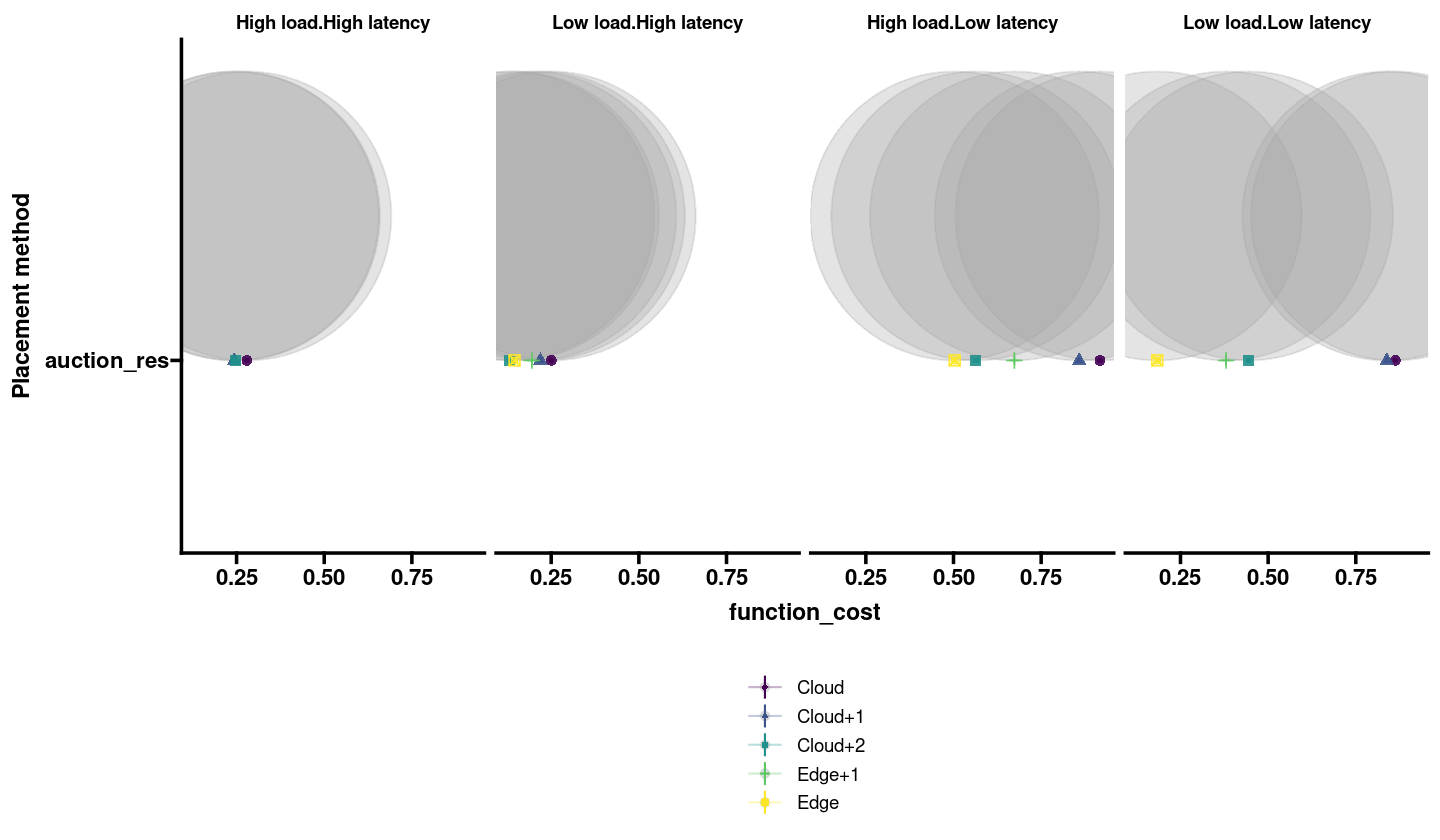

In [109]:
fig(12, 7)
value_of_bids <- bids_won_function %>%
    extract_function_name_info() %>%
    group_by(folder, metric_group, metric_group_group, winner, latency_type, load_type) %>%
    summarise(function_cost = mean(cost), nb_functions = n()) %>%
    inner_join(node_levels %>% mutate(winner = name) %>% select(-name), by = c("winner")) %>%
    group_by(folder, metric_group, metric_group_group, latency_type, load_type, level) %>%
    summarise(function_cost = mean(function_cost), nb_functions = sum(nb_functions)) %>%
    {.}

value_of_bids %>% filter(metric_group == "auction" & latency_type == "High latency" & load_type == "High load" & level =="Edge")

value_of_bids %>%
    correct_names() %>%
    ggplot(aes(
        x = function_cost,
        y = `Placement method`,
        color = level,
        shape = level
    )) +
    stat_dotsinterval() +
    # stat_dotsinterval(position = "dodge", point_interval = mode_hdci, point_alpha = 0.1) +
    gghighlight(metric_group == "auction", unhighlighted_params = list(point_alpha = 0.9, colour = NULL, fill = NULL, alpha = 0.3), label_params = list(linewidth = 10), calculate_per_facet = TRUE) +
    facet_grid(cols = vars(interaction(load_type, latency_type))) +
    #   labs(
    #     x = "Deployment time (ms)",
    #     y = "Placement algorithm",
    #     title = "Deployment time of placement models",
    #     subtitle = "Each point is an experiment run",
    #     color = "Function type",
    #     shape = "Function type",
    #   ) +
    theme(
        legend.position = "bottom",
        legend.direction = "vertical",
    )


In [110]:
grand_total_gains <- bids_won_function %>%
    group_by(folder, metric_group, metric_group_group) %>%
    summarise(grand_total = sum(cost))

`summarise()` has grouped output by 'folder', 'metric_group'. You can override using the `.groups` argument.


`summarise()` has grouped output by 'folder', 'metric_group', 'metric_group_group'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'metric_group', 'level'. You can override using the `.groups` argument.
Warning message:
“Tried to calculate with group_by(), but the calculation failed.
Falling back to ungrouped filter operation...”
Warning message:
“Using shapes for an ordinal variable is not advised”
Warning message:
“Removed 2 rows containing missing values (geom_segment).”
Warning message:
“Removed 2 rows containing missing values (geom_segment).”
Warning message:
“Removed 2 rows containing missing values (geom_segment).”
Warning message:
“Removed 2 rows containing missing values (geom_segment).”
Warning message:
“Removed 2 rows containing missing values (geom_segment).”


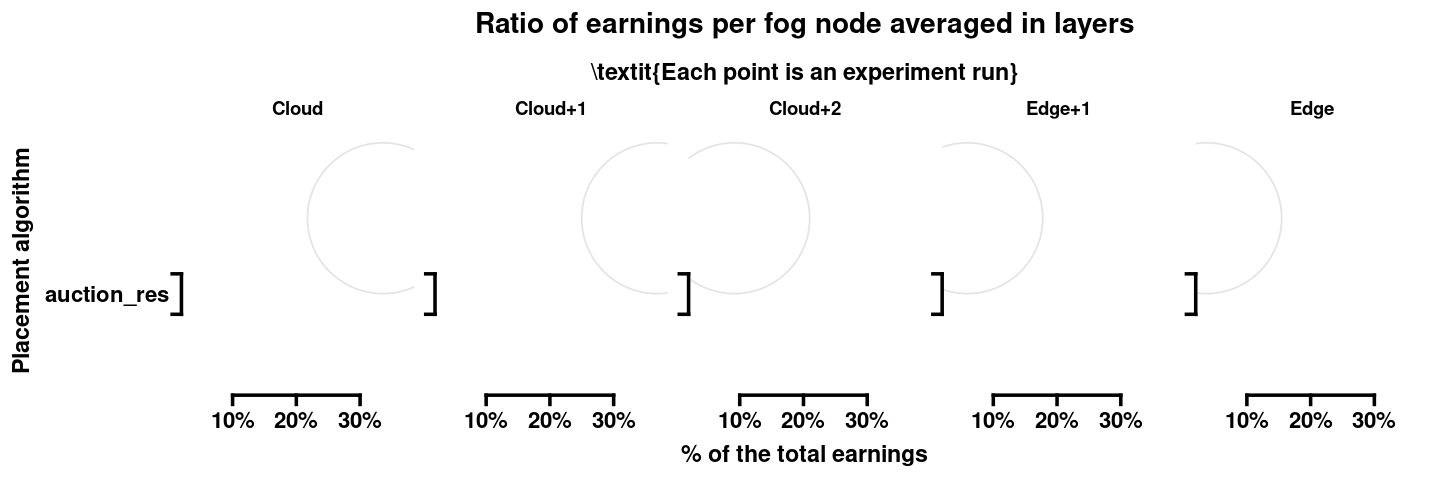

In [111]:
transform_ratio_graph <- auc_usage %>%
    mutate(winner = instance) %>%
    ungroup() %>%
    select(-instance) %>%
    inner_join(grand_total_gains, by = c("folder", "metric_group", "metric_group_group")) %>%
    inner_join(total_gains, by = c("folder", "metric_group", "metric_group_group", "winner")) %>%
    mutate(gains_ratio = earnings / grand_total) %>%
    inner_join(node_levels %>% mutate(winner = name) %>% select(-name), by = c("winner")) %>%
    {
        .
    }


folders <- transform_ratio_graph %>%
    select(folder, metric_group, metric_group_group) %>%
    distinct()
missing_data <- expand.grid(
    winner = node_levels$name,
    folder = folders$folder
) %>%
    inner_join(node_levels %>% mutate(winner = name) %>% select(-name), by = c("winner")) %>%
    inner_join(folders, by = c("folder"))

transform_ratio_graph <- transform_ratio_graph %>%
    full_join(missing_data, by = c("winner", "level", "folder", "metric_group", "metric_group_group")) %>%
    ungroup() %>%
    {
        .
    }
transform_ratio_graph$gains_ratio[is.na(transform_ratio_graph$gains_ratio)] <- 0

top_1_percent <- transform_ratio_graph %>%
    group_by(folder, metric_group, metric_group_group, level) %>%
    arrange(desc(gains_ratio), .by_group = TRUE) %>%
    mutate(rank = row_number()) %>%
    filter(rank <= ceiling(n() * 0.05)) %>%
    group_by(folder, metric_group, metric_group_group, level) %>%
    summarize(gains_ratio_1_percent = mean(gains_ratio))

transform_ratio_graph <- transform_ratio_graph %>%
    group_by(metric_group, level, folder) %>%
    summarise(gains_ratio = mean(gains_ratio)) %>%
    inner_join(top_1_percent, by = c("folder", "metric_group", "level")) %>%
    gather(key = "gains_ratio_type", value = "gains_ratio", gains_ratio, gains_ratio_1_percent) %>%
    mutate(gains_ratio_type = case_when(
        gains_ratio_type == "gains_ratio" ~ "all",
        gains_ratio_type == "gains_ratio_1_percent" ~ "5% highest",
    ))


transform_ratio_graph_plot_earnings <- transform_ratio_graph %>%
    filter(gains_ratio_type == "all") %>%
    correct_names() %>%
    ggplot(aes(
        x = gains_ratio,
        y = `Placement method`,
        color = metric_group,
        fill = metric_group,
        shape = metric_group
    )) +
    # stat_dotsinterval(binwidth = 0.0015, scale = 0.95, size = 7, slab_linewidth = 0) +
    stat_dotsinterval() +
    # stat_dotsinterval(position = "dodge", binwidth = 0.0015, scale = 0.95, size = 7, slab_linewidth = 0) +
    gghighlight(metric_group == "auction", unhighlighted_params = list(slab_alpha = 0.3, point_alpha = 0.3, colour = NULL, fill = NULL, alpha = 0.3), label_params = list(linewidth = 10), calculate_per_facet = TRUE) +
    scale_x_continuous(label = scales::percent) +
    facet_grid2(cols = vars(level), rows = vars(gains_ratio_type), axes = "all", remove_labels = "y") +
    labs(
        y = "Placement algorithm",
        x = "% of the total earnings",
        title = "Ratio of earnings per fog node averaged in layers",
        subtitle = "\\textit{Each point is an experiment run}",
        fill = "Function type",
        color = "Function type",
        shape = "Function type"
    ) +
    theme(
        legend.position = "none",
        strip.text.y = element_blank()
    ) +
    coord_capped_cart(bottom = "both") +
    scale_y_discrete(guide = guide_prism_bracket(width = 0.15))
fig(12, 4)
transform_ratio_graph_plot_earnings


In [112]:
# grand_total_gains <- bids_won_function %>%
#     group_by(folder, metric_group, metric_group_group) %>%
#     summarise(grand_total = sum(cost))

# Each point is an experiment run",
#         fill = "Function type",
#         color = "Function type",
#         shape = "Function type"
#     ) +
#     theme(
#         legend.position = "none",
#         strip.text.y = element_blank()
#     ) +
#     coord_capped_cart(bottom = "both") +
#     scale_y_discrete(guide = guide_prism_bracket(width = 0.15))
# fig(12, 4)
# transform_ratio_graph_plot_earnings


`summarise()` has grouped output by 'folder'. You can override using the `.groups` argument.


x_category,min,max,med,size,max_size,scale
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<list>
b1,84.08,84.08,84.08,0,0,<environment: 0xcf44808>


folder,metric_group,earnings,x_category
<chr>,<chr>,<dbl>,<fct>
metrics_valuation_rates_bigger_1-auction_valuation_resources_no-telemetry_2023-05-16-12-40,auction_res,84.08399,b1


Warning message:
“Ignoring unknown parameters: slab_linewidth”
Warning message:
“Using shapes for an ordinal variable is not advised”
Warning message:
“Removed 2 rows containing missing values (geom_segment).”


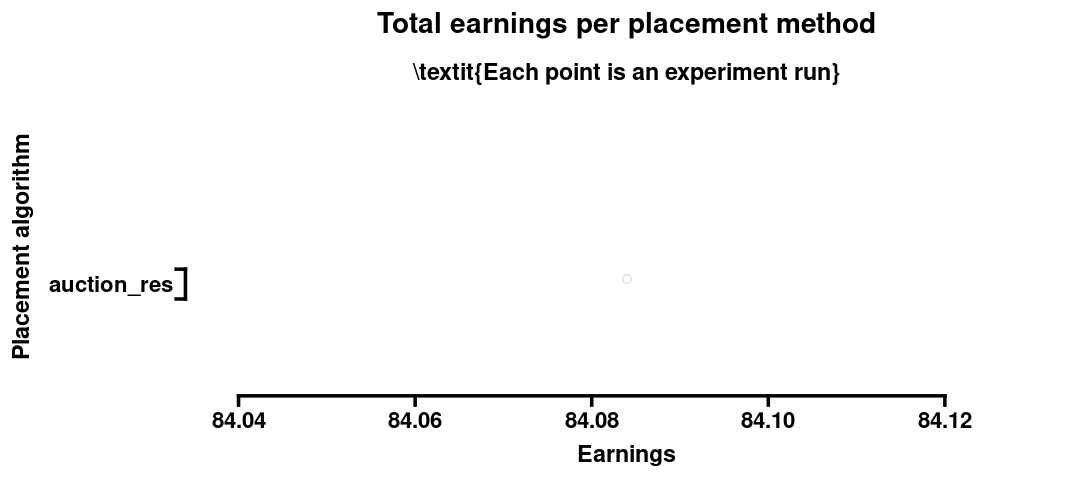

In [113]:
# transform_ratio_graph <- auc_usage %>%
#     mutate(winner = instance) %>%
#     ungroup() %>%
#     select(-instance) %>%
#     inner_join(grand_total_gains, by = c("folder", "metric_group", "metric_group_group")) %>%
#     inner_join(total_gains, by = c("folder", "metric_group", "metric_group_group", "winner")) %>%
#     # mutate(gains_ratio = earnings / grand_total) %>%
#     inner_join(node_levels %>% mutate(winner = name) %>% select(-name), by = c("winner")) %>%
#     {
#         .
#     }

# folders <- transform_ratio_graph %>%
#     select(folder, metric_group, metric_group_group) %>%
#     distinct()
# missing_data <- expand.grid(
#     winner = node_levels$name,
#     folder = folders$folder
# ) %>%
#     inner_join(node_levels %>% mutate(winner = name) %>% select(-name), by = c("winner")) %>%
#     inner_join(folders, by = c("folder"))

# transform_ratio_graph <- transform_ratio_graph %>%
#     full_join(missing_data, by = c("winner", "level", "folder", "metric_group", "metric_group_group")) %>%
#     ungroup() %>%
#     {
#         .
#     }
# # transform_ratio_graph$gains_ratio[is.na(transform_ratio_graph$gains_ratio)] <- 0
# transform_ratio_graph$earnings[is.na(transform_ratio_graph$earnings)] <- 0

# top_1_percent <- transform_ratio_graph %>%
#     group_by(folder, metric_group, metric_group_group) %>%
#     arrange(desc(earnings), .by_group = TRUE) %>%
#     mutate(rank = row_number()) %>%
#     filter(rank <= ceiling(n() * 0.05)) %>%
#     group_by(folder, metric_group, metric_group_group) %>%
#     summarize(earnings_1_percent = mean(earnings), earnings_sum_1_percent = sum(earnings))

# transform_ratio_graph <- transform_ratio_graph %>%
#     group_by(metric_group, folder) %>%
#     summarise(earnings_avg = mean(earnings), earnings_sum = sum(earnings)) %>%
#     inner_join(top_1_percent, by = c("folder", "metric_group")) %>%
#     gather(key = "earnings_type", value = "earnings", earnings_avg, earnings_1_percent, earnings_sum, earnings_sum_1_percent) %>%
#     mutate(earnings_type = case_when(
#         earnings_type == "earnings_avg" ~ "all avg",
#         earnings_type == "earnings_1_percent" ~ "5% highest avg",
#         earnings_type == "earnings_sum" ~ "all sum",
#         earnings_type == "earnings_sum_1_percent" ~ "5% highest sum",
#     ))


# # transform_ratio_graph_plot_earnings <- transform_ratio_graph %>%
# #     filter(earnings_type == "all sum") %>%
# #     correct_names() %>%
# #     ggplot(aes(
# #         x = earnings,
# #         y = `Placement method`,
# #         color = metric_group,
# #         fill = metric_group,
# #         shape = metric_group
# #     )) +
# #     stat_dotsinterval(position = "dodge", binwidth = 0.0015, scale = 0.95, size = 7, slab_linewidth = 0) +
# #     gghighlight(metric_group == "auction", unhighlighted_params = list(slab_alpha = 0.3, point_alpha = 0.3, colour = NULL, fill = NULL, alpha = 0.3), label_params = list(linewidth = 10), calculate_per_facet = TRUE) +
# #     # scale_x_continuous(label = scales::percent) +
# #     facet_grid2(rows = vars(earnings_type), axes = "all", remove_labels = "y", scales="free_x") +
# #     labs(
# #         y = "Placement algorithm",
# #         x = "% of the total earnings",
# #         title = "Ratio of earnings per fog node averaged in layers",
# #         fill = "Function type",
# #         color = "Function type",
# #         shape = "Function type"
# #     ) +
# #     theme(
# #         legend.position = "none",
# #     ) +
# #     coord_capped_cart(bottom = "both") +
# #     scale_y_discrete(guide = guide_prism_bracket(width = 0.15))
# # fig(12, 7)
# # transform_ratio_graph_plot_earnings
grand_total_gains_local <- grand_total_gains %>%
  group_by(folder, metric_group) %>%
  summarise(earnings = sum(grand_total))
categorize_x <- function(x) {
  if (x <= 130000) {
    return("b1")
  } else {
    return("b2")
  }
}

grand_total_gains_local$x_category <- as.factor(sapply(grand_total_gains_local$earnings, categorize_x))

maxmin <- grand_total_gains_local %>%
  group_by(x_category) %>%
  summarise(min = min(earnings), max = max(earnings), med = median(earnings)) %>%
  mutate(min = -1 * round(-1 * min, 2), max = round(max, 2)) %>%
  mutate(size = max - min)

maxmin <- maxmin %>%
  full_join(maxmin %>% ungroup() %>% summarise(max_size = max(size)), by = character()) %>% # cross join
  mutate(max_size = round(max_size * 1.33, 2), med = round(med, 2)) %>%
  mutate(min = -1 * round(-1 * (med - max_size / 2), 2), max = round(med + max_size / 2, 2)) %>%
  rowwise() %>%
  mutate(scale = c(scale_x_continuous(limits = c(min, max), breaks = seq(min, max, max_size / 2))))

maxmin
grand_total_gains_local
transform_ratio_graph_plot_sum_earnings <- grand_total_gains_local %>%
  correct_names() %>%
  ggplot(aes(
    x = earnings,
    y = `Placement method`,
    color = metric_group,
    fill = metric_group,
    shape = metric_group
  )) +
  stat_dotsinterval(position = "dodge", binwidth = unit(2, "mm"), scale = 0.95, size = 7, slab_linewidth = 0) +
  gghighlight(metric_group == "auction", unhighlighted_params = list(slab_alpha = 0.3, point_alpha = 0.3, colour = NULL, fill = NULL, alpha = 0.3), label_params = list(linewidth = 10), calculate_per_facet = TRUE) +
  # scale_x_continuous(label = scales::percent) +
  # facet_grid2(rows = vars(earnings_type), axes = "all", remove_labels = "y", scales="free_x") +
  labs(
    y = "Placement algorithm",
    x = "Earnings",
    title = "Total earnings per placement method",
    subtitle = "\\textit{Each point is an experiment run}",
    fill = "Function type",
    color = "Function type",
    shape = "Function type"
  ) +
  theme(
    legend.position = "none",
    strip.text.x = element_blank()

  ) +
  # facet_grid2(cols = vars(x_category), scales = "free_x") +
  # facetted_pos_scales(
  #   x = list(
  #     maxmin$scale[[1]],
  #     maxmin$scale[[2]]
  #   )
  # ) +
  # coord_cartesian(clip = "off") +
  # guides(x = guide_axis_truncated(trunc_lower = c(maxmin$min[[2]], maxmin$min[[1]]), trunc_upper = c(maxmin$max[[2]], maxmin$max[[1]]))) +
  # annotate("text", x = c(0, maxmin$max[[1]]), y = 0, label = "/ /", size = 10, vjust = 0.5) +
  scale_y_discrete(guide = guide_prism_bracket(width = 0.1)) +
  coord_capped_cart(bottom='both')

  # guides(x = guide_axis_truncated(trunc_lower = maxmin$min, trunc_upper = maxmin$max))



fig(9, 4)
transform_ratio_graph_plot_sum_earnings


`summarise()` has grouped output by 'metric_group'. You can override using the `.groups` argument.
Warning message:
“Ignoring unknown parameters: slab_linewidth”
Warning message:
“Using shapes for an ordinal variable is not advised”
Warning message:
“Removed 2 rows containing missing values (geom_segment).”


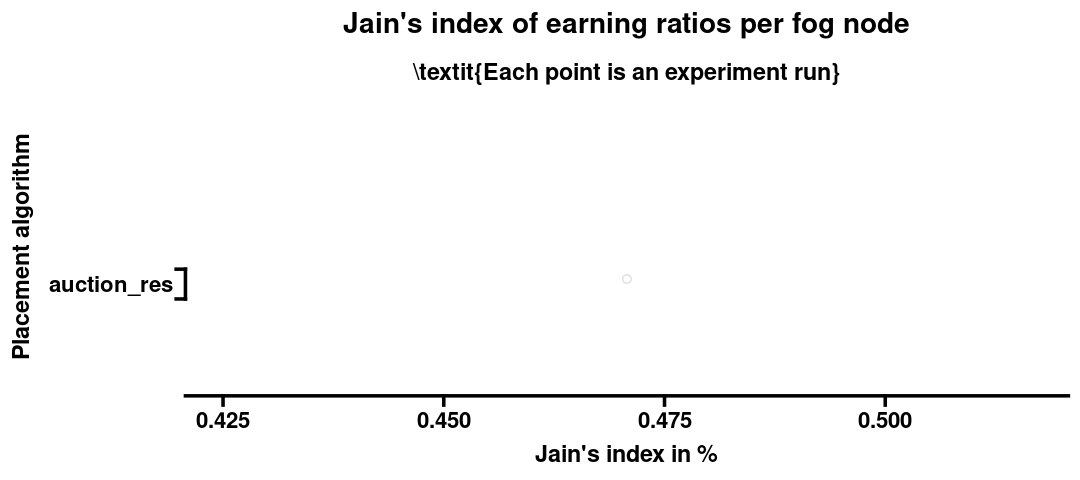

In [114]:
# Define a function to calculate Jain's Faisrness Index
jains_index <- function(allocations) {
  num_users <- length(allocations)
  sum_allocations <- sum(allocations)
  sum_square_allocations <- sum(allocations^2)

  index <- (sum_allocations^2) / (num_users * sum_square_allocations)
  return(index)
}

transform_ratio_graph <- auc_usage %>%
  mutate(winner = instance) %>%
  ungroup() %>%
  select(-instance) %>%
  inner_join(grand_total_gains, by = c("folder", "metric_group", "metric_group_group")) %>%
  inner_join(total_gains, by = c("folder", "metric_group", "metric_group_group", "winner")) %>%
  mutate(gains_ratio = earnings / grand_total) %>%
  {
    .
  }


folders <- transform_ratio_graph %>%
  select(folder, metric_group, metric_group_group) %>%
  distinct()
missing_data <- expand.grid(
  winner = node_levels$name,
  folder = folders$folder
) %>%
  inner_join(node_levels %>% mutate(winner = name) %>% select(-name), by = c("winner")) %>%
  inner_join(folders, by = c("folder"))

transform_ratio_graph <- transform_ratio_graph %>%
  full_join(missing_data, by = c("winner", "folder", "metric_group", "metric_group_group")) %>%
  ungroup() %>%
  {
    .
  }
transform_ratio_graph$gains_ratio[is.na(transform_ratio_graph$gains_ratio)] <- 0

# Calculate Jain's Fairness Index for each group using dplyr
transform_ratio_graph <- transform_ratio_graph %>%
  group_by(metric_group, folder) %>%
  summarise(jains_index = jains_index(gains_ratio), n = n())

# top_1_percent <- transform_ratio_graph %>%
#   group_by(folder, metric_group, metric_group_group, level) %>%
#   arrange(desc(gains_ratio), .by_group = TRUE) %>%
#   mutate(rank = row_number()) %>%
#   filter(rank <= ceiling(n() * 0.05)) %>%
#   group_by(folder, metric_group, metric_group_group, level) %>%
#   summarize(gains_ratio_1_percent = mean(gains_ratio))

# transform_ratio_graph <- transform_ratio_graph %>%
#   # group_by(metric_group, level, folder) %>%
#   # summarise(gains_ratio = mean(gains_ratio)) %>%
#   # inner_join(top_1_percent, by = c("folder", "metric_group", "level")) %>%
#   gather(key = "gains_ratio_type", value = "gains_ratio", gains_ratio, gains_ratio_1_percent) %>%
#   mutate(gains_ratio_type = case_when(
#     gains_ratio_type == "gains_ratio" ~ "all",
#     gains_ratio_type == "gains_ratio_1_percent" ~ "5% highest",
#   ))

# transform_ratio_graph
categorize_x <- function(x) {
  if (x <= 0.56) {
    return("b1")
  } else {
    return("b2")
  }
}

transform_ratio_graph$x_category <- as.factor(sapply(transform_ratio_graph$jains_index, categorize_x))

maxmin <- transform_ratio_graph %>%
  group_by(x_category) %>%
  summarise(min = min(jains_index), max = max(jains_index), med = median(jains_index)) %>%
  mutate(min = -1 * round(-1 * min, 2), max = round(max, 2)) %>%
  mutate(size = max - min)

maxmin <- maxmin %>%
  full_join(maxmin %>% ungroup() %>% summarise(max_size = max(size)), by = character()) %>%
  mutate(max_size = round(max_size * 1.33, 2), med = round(med, 2)) %>%
  mutate(min = -1 * round(-1 * (med - max_size / 2), 2), max = round(med + max_size / 2, 2)) %>%
  rowwise() %>%
  mutate(scale = c(scale_x_continuous(limits = c(min, max), breaks = seq(min, max, max_size / 2), label = scales::percent)))
# mutate(scale = c(scale_x_continuous(limits = c(0, 1), breaks = seq(0, 1, 0.10), label = scales::percent)))

# transform_ratio_graph
fig(12, 6)
transform_ratio_graph_plot_jain <- transform_ratio_graph %>%
  correct_names() %>%
  ggplot(aes(
    x = jains_index,
    y = `Placement method`,
    color = metric_group,
    fill = metric_group,
    shape = metric_group
  )) +
  stat_dotsinterval(position = "dodge", binwidth = unit(2, "mm"), scale = 0.95, size = 7, slab_linewidth = 0) +
  gghighlight(metric_group == "auction", unhighlighted_params = list(slab_alpha = 0.3, point_alpha = 0.3, colour = NULL, fill = NULL, alpha = 0.3), label_params = list(linewidth = 10), calculate_per_facet = TRUE) +
  labs(
    y = "Placement algorithm",
    x = "Jain's index in %",
    title = "Jain's index of earning ratios per fog node",
    subtitle = "\\textit{Each point is an experiment run}",
    fill = "Function type",
    color = "Function type",
    shape = "Function type"
  ) +
  theme(
    legend.position = "none",
    strip.text.x = element_blank()
  ) +
  # facet_grid2(cols = vars(x_category), scales = "free_x") +
  # facetted_pos_scales(
  #   x = list(
  #     maxmin$scale[[1]],
  #     maxmin$scale[[2]]
  #   )
  # ) +
  coord_cartesian(clip = "off") +
  # guides(x = guide_axis_truncated(trunc_lower = maxmin$min, trunc_upper = maxmin$max)) +
  # annotate("text", x = maxmin$max[[1]] + 0.003, y = 0, label = "/ /", size = 10, vjust = 0.5) +
  scale_y_discrete(guide = guide_prism_bracket(width = 0.1))

fig(9, 4)
transform_ratio_graph_plot_jain
# theme(
#   legend.position = "none",
#   # axis.line.x = element_blank()
#   plot.margin = margin(l = 0),
#   axis.line.y = element_blank()
# )


## Latencies and SLAs

In [115]:
# echo_sum <-
#   load_csv("echo_function_http_request_to_processing_echo_duration_seconds_print_sum.csv") %>%
#   prepare()

# echo_count <-
#   load_csv("echo_function_http_request_to_processing_echo_duration_seconds_print_count.csv") %>%
#   prepare()

echo_bucket_raw <-
  load_csv("echo_function_http_request_to_processing_echo_duration_seconds_print_bucket.csv") %>%
  prepare() %>%
  mutate(function_name = tag)

latencies <- echo_bucket_raw %>%
  select(function_name, folder, metric_group_group) %>%
  distinct() %>%
  extract_function_name_info() %>%
  select(latency, folder, metric_group_group)


Rows: 166452 Columns: 9
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (5): name, instance, job, sla_id, tag
dbl (4): le, period, timestamp, value

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [116]:
errors <- tryCatch(
    {
        load_csv("iot_emulation_http_request_to_processing_echo_fails.csv") %>%
            prepare() %>%
            extract_function_name_info() %>%
            distinct()
    },
    error = function(cond) {
        columns <- c("instance", "job", "timestamp", "tag", "period", "folder", "metric_group", "latency", "value")
        df <- data.frame(instance = character(0), job = character(0), period = numeric(0), folder = character(0), metric_group = character(0), latency = character(0), value = numeric(0))
        return(df)
    }
)


Rows: 17304 Columns: 7
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (4): name, instance, job, tag
dbl (3): period, timestamp, value

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Warning message in min.default(structure(numeric(0), tzone = "", class = c("POSIXct", :
“aucun argument trouvé pour min ; Inf est renvoyé”
Warning message:
“Unknown or uninitialised column: `function_name`.”


In [117]:
echo_bucket <- echo_bucket_raw %>%
    mutate(value_bucket = value) %>%
    select(-value) %>%
    mutate(le = ifelse(le == "Inf", Inf, as.numeric(le))) %>%
    extract_function_name_info() %>%
    mutate(latency = as.numeric(latency) / 1000) %>%
    mutate(load = 1000 / as.numeric(period)) %>%
    {
        .
    }


In [118]:
average_sum <- echo_bucket %>%
    select(load, sla_id, function_name, folder, le, value_bucket, latency, timestamp, metric_group, metric_group_group, latency_type, load_type, nb_fn_low_interval_low_latency, nb_fn_high_interval_low_latency) %>%
    inner_join(bids_won_function %>% select(sla_id, function_name, metric_group, metric_group_group, folder, winner), by = c("sla_id", "function_name", "folder", "metric_group_group", "metric_group")) %>%
    arrange(desc(timestamp), .by_group = TRUE) %>%
    group_by(function_name, sla_id, winner, load, folder, le, latency, metric_group, metric_group_group, latency_type, load_type, nb_fn_low_interval_low_latency, nb_fn_high_interval_low_latency) %>%
    filter(row_number() == n()) %>% # Last measure
    # select(-timestamp) %>%
    arrange(desc(le), .by_group = TRUE) %>%
    {
        .
    }

# head(average_sum)

under_sla <- average_sum %>%
    mutate(target_offset = round(le - latency, 3)) %>%
    filter(target_offset %in% c(-0.003, -0.002, -0.001, 0, 0.003, 0.002, 0.001)) %>%
    group_by(timestamp, sla_id, function_name, winner, load, folder, latency, target_offset, metric_group, metric_group_group, latency_type, load_type, nb_fn_low_interval_low_latency, nb_fn_high_interval_low_latency) %>%
    select(-le) %>%
    {
        .
    }

# under_sla

sla_stats <- average_sum %>%
    filter(le == Inf) %>%
    group_by(timestamp, sla_id, function_name, winner, load, folder, latency, metric_group, metric_group_group, latency_type, load_type, nb_fn_low_interval_low_latency, nb_fn_high_interval_low_latency) %>%
    mutate(total = value_bucket) %>%
    select(-c(value_bucket, le)) %>%
    inner_join(under_sla, by = c("sla_id", "timestamp", "function_name", "winner", "load", "folder", "metric_group_group", "latency", "metric_group", "latency_type", "load_type", "nb_fn_low_interval_low_latency", "nb_fn_high_interval_low_latency")) %>%
    mutate(above = total - value_bucket) %>%
    {
        .
    }

# sla_stats


In [119]:
apdex_data <- sla_stats %>%
    filter(target_offset == 0) %>%
    mutate(satisfied_count = value_bucket) %>%
    select(-c(target_offset, above, value_bucket)) %>%
    inner_join(sla_stats %>% filter(target_offset == 0.003) %>% mutate(value_tolerated =value_bucket) %>% select(-c(value_bucket, target_offset, above)), by = c("sla_id", "function_name", "load", "latency", "load_type", "latency_type", "folder", "metric_group", "metric_group_group", "nb_fn_low_interval_low_latency", "nb_fn_high_interval_low_latency", "timestamp", "winner", "total")) %>%
    group_by(sla_id, folder, metric_group, metric_group_group) %>%
    distinct() %>%
    mutate(tolerating_count = value_tolerated - satisfied_count) %>%
    mutate(apdex = (satisfied_count + 0.5 * tolerating_count) / total) %>%
    mutate(apdex_inv = 1 - apdex) %>%
    inner_join(node_levels %>% mutate(winner = name) %>% select(-name), by = c("winner")) %>%
    {
        .
    }
    # apdex_data %>% filter(sla_id == "00171506-f0f4-4a64-952b-7a5d1902b2bf")

In [120]:
total_low_latency <- functions_total %>%
  filter(status == "provisioned") %>%
  filter(latency_type == "Low latency") %>%
  group_by(folder, metric_group, metric_group_group, latency_type) %>%
  summarise(total = sum(total))

total <- functions_total %>%
  filter(status == "provisioned") %>%
  group_by(folder, metric_group, metric_group_group) %>%
  summarise(total = sum(total))

total_low_latency <- total_low_latency %>%
  group_by(folder, metric_group, metric_group_group) %>%
  inner_join(total, by = c("folder", "metric_group", "metric_group_group")) %>%
  mutate(ratio_low_latency_functions = total.x / total.y) %>%
  select(folder, metric_group, metric_group_group, ratio_low_latency_functions)


ratio_low_latency <- functions_total %>%
  filter(latency_type == "Low latency") %>%
  filter(status == "provisioned") %>%
  group_by(folder, metric_group, metric_group_group) %>%
  summarise(n = sum(n)) %>%
  inner_join(total, by = c("metric_group", "folder", "metric_group_group")) %>%
  mutate(ratio_low_latency = n / total)

ratio_total <- functions_total %>%
  filter(status == "provisioned") %>%
  group_by(folder, metric_group, metric_group_group) %>%
  summarise(n = sum(n)) %>%
  inner_join(total, by = c("metric_group", "folder", "metric_group_group")) %>%
  mutate(ratio_total = n / total)

`summarise()` has grouped output by 'folder', 'metric_group', 'metric_group_group'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'folder', 'metric_group'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'folder', 'metric_group'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'folder', 'metric_group'. You can override using the `.groups` argument.


In [121]:
apdex_data_line <- apdex_data %>%
  inner_join(total_low_latency, by = c("folder", "metric_group", "metric_group_group")) %>%
  mutate(satisfied = 1 - satisfied_count / total) %>%
  ungroup()
  
#   apdex_data_line_point <- apdex_data_line %>% filter(metric_group == "auction")
# # apdex_data_line
# point_ninetynine_percent <- ecdf(apdex_data_line_point$apdex)(0.99)
# point_ninetynine_percent <- data.frame(x = 0.99, y=point_ninetynine_percent)
# point_ninety_percent <- ecdf(apdex_data_line_point$apdex)(0.95)
# point_ninety_percent <- data.frame(x = 0.95, y=point_ninety_percent)

# fig(10, 7)
# # tikz(file = "ecdf_apdex", width=11.692, height=8.267)
# apdex_data_line %>%
# # filter(metric_group %in% c("auction", "edge_furthest")) %>%
#   ggplot(
#     aes(
#       x = apdex,
#       # y = value,
#       colour = metric_group,
#       # line_type= metric_group
#       # group = folder
#     )
#   ) +
#   geom_point(data = point_ninetynine_percent, aes(x, y, label=y),  color="darkorange1", size = 3) +
#   geom_point(data = point_ninety_percent, aes(x, y, label=y),  color="red", size = 3) +

#   # stat_ecdf(aes(x = satisfied, alpha=0.3)) +
#   stat_ecdf() +
#   # geom_density() +
#   # geom_line(
#   # #   # aes(y=1-..y..),
#   # #   stat="ecdf"
#   #   ) +
#   gghighlight(metric_group == "auction",  unhighlighted_params = list(colour = NULL, alpha = 0.3),  label_params = list(linewidth = 10)) +
#   # stat_ecdf(aes(x = apdex_inv, group = folder), alpha = 0.3, linetype="dashed") +
#   scale_x_continuous(label = scales::percent) +
#     # scale_x_continuous(trans=c("reverse", "log10")) + #limits = c(0.0, 1), breaks = seq(0.0, 1, 0.01), expand = c(0, 0)) +
#   scale_y_continuous(label = scales::percent) +
#   # scale_x_continuous(trans = "log10", label = scales::percent) +
#   # scale_y_continuous(trans = "log10", label = scales::percent) +
#   # facet_grid(rows = varslatency_type) +
#   # facet_grid(rows = vars(level), cols = vars(latency_type)) +
#   # facet_grid(rows = vars(ratio_low_latency_functions), cols = vars(metric_group_group), scales = "free") +
#   # facet_grid(rows = vars(ratio_low_latency_functions), cols = vars(metric_group_group), scales = "free") +
#   geom_textvline(aes(xintercept = 0.95, label = "95%"), lty = 1, colour = "red") +
#   geom_textvline(aes(xintercept = 0.99, label = "99%"), lty = 2, colour = "darkorange1") +
#   coord_cartesian(xlim = c(0.95, 1), ylim = c(0, 1)) +
#   geom_text(data = point_ninetynine_percent, aes(x, y, label = paste0(round(y*100, 1), "%")),
#           hjust = 1.2, vjust = -0.8, size = 5, color = "darkorange1") +
#   geom_text(data = point_ninety_percent, aes(x, y, label = paste0(round(y*100, 1), "%")),
#           hjust = -0.5, vjust = -0.8, size = 5, color = "red") +
#   labs(
#     x = "apdex in %",
#     y = "% of functions",
#     title = "Empirical Cumulative Distribution Function of Apdex score",
#     color = "Placement model"
#   )


`summarise()` has grouped output by 'metric_group', 'folder'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'metric_group', 'folder', 'metric_group_group', 'ratio_low_latency'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'metric_group', 'folder', 'metric_group_group', 'ratio_low_latency'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'metric_group', 'folder'. You can override using the `.groups` argument.
Warning message:
“attributes are not identical across measure variables;
they will be dropped”
Warning message:
“attributes are not identical across measure variables;
they will be dropped”


total_score.x,metric_group,folder,score_type,score,score_type_rich,data_focus,total_score.y
<drtn>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<drtn>
0.6481276 secs,auction_res,metrics_valuation_rates_bigger_1-auction_valuation_resources_no-telemetry_2023-05-16-12-40,apdex,0.9776000,$apdexScore$,all,NA secs
0.6481276 secs,auction_res,metrics_valuation_rates_bigger_1-auction_valuation_resources_no-telemetry_2023-05-16-12-40,diff,0.4812500,Ratio of aimed low latency functions deployed,all,NA secs
0.6481276 secs,auction_res,metrics_valuation_rates_bigger_1-auction_valuation_resources_no-telemetry_2023-05-16-12-40,usage,0.4855328,Ratio of total CPU reservation space used,all,NA secs
NA secs,auction_res,metrics_valuation_rates_bigger_1-auction_valuation_resources_no-telemetry_2023-05-16-12-40,apdex,0.5590917,$apdexScore$,worst 5%,0.4467958 secs
NA secs,auction_res,metrics_valuation_rates_bigger_1-auction_valuation_resources_no-telemetry_2023-05-16-12-40,usage,0.3000457,Ratio of total CPU reservation space used,worst 5%,0.4467958 secs


Warning message:
“Ignoring unknown parameters: slab_linewidth”
Warning message:
“Tried to calculate with group_by(), but the calculation failed.
Falling back to ungrouped filter operation...”
Coordinate system already present. Adding new coordinate system, which will replace the existing one.



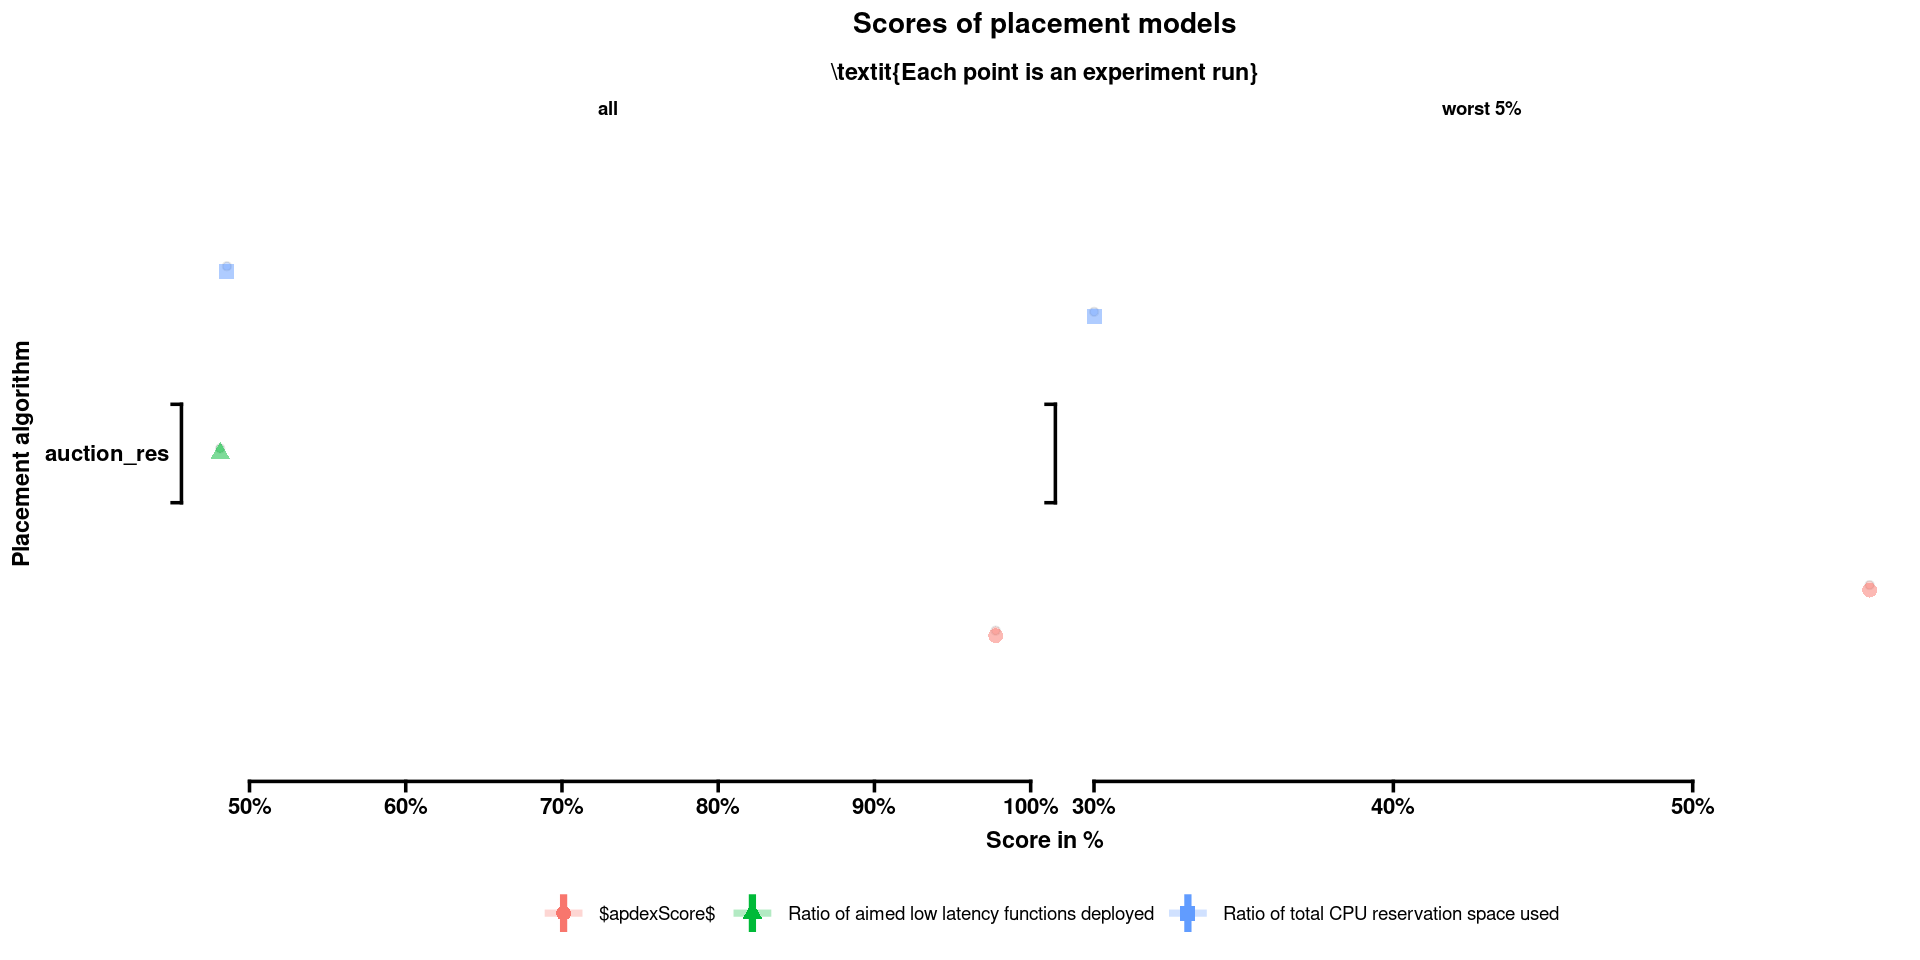

In [122]:
auc_usage_here <- auc_usage %>%
  group_by(metric_group, folder, metric_group_group) %>%
  summarise(usage = mean(usage_ratio))

apdex_plot <- apdex_data_line %>%
  inner_join(ratio_low_latency, by = c("metric_group", "metric_group_group", "folder")) %>%
  group_by(metric_group, folder, metric_group_group, ratio_low_latency, ratio_low_latency_functions) %>%
  summarise(apdex = mean(apdex)) %>%
  inner_join(auc_usage_here, by = c("metric_group", "metric_group_group", "folder")) %>%
  {
    .
  }

apdex_plot_1_percent <- apdex_data_line %>%
  inner_join(ratio_low_latency, by = c("metric_group", "metric_group_group", "folder")) %>%
  group_by(metric_group, folder, metric_group_group, ratio_low_latency, ratio_low_latency_functions) %>%
  arrange(apdex, .by_group = T) %>%
  mutate(rank = row_number()) %>%
  filter(rank <= ceiling(n() * 0.05)) %>%
  summarise(apdex = mean(apdex)) %>%
  inner_join(auc_usage %>%
    group_by(metric_group, folder, metric_group_group) %>%
    arrange(usage, .by_group = T) %>%
    mutate(rank = row_number()) %>%
    filter(rank <= ceiling(n() * 0.05)) %>%
    summarise(usage = mean(usage_ratio)), by = c("metric_group", "metric_group_group", "folder"))
finish_touch <- function(x) {
  return(x %>%
    mutate(diff = ratio_low_latency / ratio_low_latency_functions) %>%
    mutate(total_score = 1 / 3 * (diff + apdex + usage)) %>%
    group_by(metric_group, folder) %>%
    select(total_score, usage, diff, apdex, metric_group, folder) %>%
    gather(key = "score_type", value = "score", apdex, diff, usage) %>%
    mutate(score_type_rich = case_when(
      score_type == "apdex" ~ "$apdexScore$",
      score_type == "diff" ~ "Ratio of aimed low latency functions deployed",
      score_type == "usage" ~ "Ratio of total CPU reservation space used",
      score_type == "total_score" ~ "Average of all scores"
    )) %>%
    {
      .
    })
}

apdex_plot <- finish_touch(apdex_plot) %>%
  mutate(data_focus = "all") %>%
  full_join(finish_touch(apdex_plot_1_percent) %>% filter(score_type != "diff") %>% mutate(data_focus = "worst 5%"), by = c("folder", "metric_group", "data_focus", "score_type", "score", "score_type_rich"))

apdex_plot
fig(16, 8)
apdex_plot <- apdex_plot %>%
  correct_names() %>%
  ggplot(
    aes(
      y = `Placement method`,
      x = score,
      color = score_type_rich,
      shape = score_type_rich,
      fill = score_type_rich,
    )
  ) +
  # stat_dotsinterval(dotsize = 0.6, position = "dodge") +
  # gghighlight(metric_group == "auction", unhighlighted_params = list(dotsize = 0.6, colour = NULL, fill = NULL, alpha = 0.3), label_params = list(linewidth = 10)) +
  # stat_dotsinterval(quantiles=100,position = "dodge", bindwidth = 1.6, dotsize = 1.6, scale = 0.9) +
  # gghighlight(metric_group == "auction", unhighlighted_params = list(point_alpha = 0.9, scale = 0.9, bindwidth = 1.6, dotsize = 1.6, colour = NULL, fill = NULL, alpha = 0.3), label_params = list(linewidth = 10), calculate_per_facet = TRUE) +
  stat_dotsinterval(slab_alpha =0.6, position = "dodge", binwidth = unit(2, "mm"), scale = 0.95, size = 10, slab_linewidth = 0) +
  gghighlight(metric_group == "auction", unhighlighted_params = list(slab_alpha = 0.3, point_alpha = 0.3, colour = NULL, fill = NULL, alpha = 0.3), label_params = list(linewidth = 10), calculate_per_facet = TRUE) +
  facet_grid2(cols = vars(data_focus), scales = "free_x", axes = "all", remove_labels = "y") +
  scale_x_continuous(label = scales::percent) +
  coord_cartesian(clip="off") +
  labs(
    x = "Score in %",
    y = "Placement algorithm",
    title = "Scores of placement models",
    subtitle = "\\textit{Each point is an experiment run}",
    color = "Score type",
    fill = "Score type",
    shape = "Score type"
  ) +
  theme(
    legend.position = "bottom",
    # panel.border=element_blank(), axis.line=element_line()
    # legend.direction = "vertical",
  ) +
  coord_capped_cart(bottom='both')+
  # capped_horizontal(capped = c("both", "left", "right", "none")) +
  # scale_x_continuous(guide = capped_horizontal(capped = c("both", "left", "right", "none"))) +
  scale_y_discrete(guide = guide_prism_bracket(width = 0.15))

apdex_plot


`summarise()` has grouped output by 'folder'. You can override using the `.groups` argument.


folder,period,failed
<chr>,<dbl>,<dbl>


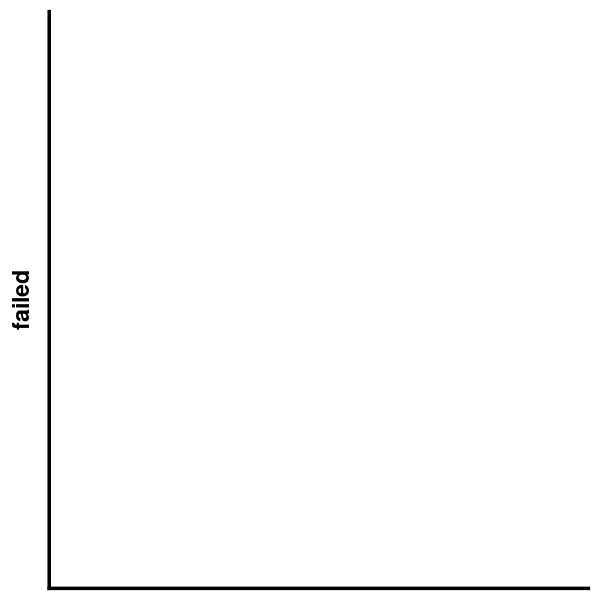

In [123]:
fails <- errors %>%
  group_by(folder, period) %>%
  summarise(failed = sum(value))

fails <- fails %>%
  # mutate(load = 1000 / period) %>%
  # inner_join(evol_sla_data, c("folder", "load")) %>%
  # mutate(dropped = failed / (above + respected + failed)) %>%
  {
    .
  }

fails

# fails <- evol_sla_data %>%
#     group_by(folder, target_offset) %>%
#     select(folder, target_offset) %>%
#     left_join(fails, by = c("folder")) %>%
#     {.}
# fails$dropped <- coalesce(fails$dropped, 0)


fails <- fails %>%
  ggplot(
    aes(
      x = folder,
      y = failed,
      # color = latency_type,
    )
  ) +
  # geom_line() +
  geom_point() +
  # geom_rug(sides="l") +
  # scale_y_reverse(label=scales::percent) +
  # scale_y_reverse()+
  # scale_x_discrete(position = "top") +
  # labs(
  #   x = "Load (req/s)",
  #   y = "Errors",
  #   # title = "Ratio of errors for send window vs load.",
  #   color = "Placment model"
  # ) +
  theme(
    axis.title.x = element_blank()
  ) +
  scale_color_viridis(discrete = TRUE, option = "D") +
  scale_fill_viridis(discrete = TRUE)

fig(5, 5)
fails
# cowplot::plot_grid(evol_sla, fails, ncol = 1, rel_heights = c(1, 0.75))


In [124]:
deployment_times_raw <-
  load_csv("market_function_deployment_time.csv") %>%
  prepare() %>%
  extract_function_name_info()

# head(deployment_times_raw)


Rows: 88290 Columns: 8
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (6): name, bid_id, function_name, instance, job, sla_id
dbl (2): timestamp, value

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [125]:
deployment_times <- deployment_times_raw %>%
  select(load_type, bid_id, latency_type, function_name, metric_group, value, metric_group_group) %>%
  distinct() %>%
  drop_na() %>%
  group_by(load_type, latency_type, bid_id, function_name, metric_group, metric_group_group) %>%
  summarize(min_time = min(value), avg_time = mean(value), max_time = max(value)) %>%
  {
    .
  }

# head(deployment_times)
fig(10, 10)
toto <- deployment_times %>%
  ggplot(
    aes(
      x = avg_time * 1000,
      # y = value,
      color = metric_group,
    )
  ) +
  stat_ecdf() +
  gghighlight(metric_group == "auction",  unhighlighted_params = list(colour = NULL, alpha = 0.3),  label_params = list(linewidth = 10)) +
  scale_x_continuous(trans = "log10") +
  # facet_grid(rows = varslatency_type) +
  # facet_grid(rows = vars(latency_type), cols = vars(load_type), scales = "free") +
  labs(
    x = "Deployment time (ms)",
    y = "Cumulation",
    title = "ECDF of time to deploy functions",
    color = "Placement model"
  ) 
  # scale_color_viridis(discrete = TRUE, option = "D") +
  # scale_fill_viridis(discrete = TRUE)


`summarise()` has grouped output by 'load_type', 'latency_type', 'bid_id', 'function_name', 'metric_group'. You can override using the `.groups` argument.
Warning message:
“Tried to calculate with group_by(), but the calculation failed.
Falling back to ungrouped filter operation...”


`summarise()` has grouped output by 'folder', 'metric_group', 'metric_group_group'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'folder', 'metric_group', 'metric_group_group'. You can override using the `.groups` argument.
Warning message:
“Ignoring unknown parameters: slab_linewidth”
Warning message:
“Tried to calculate with group_by(), but the calculation failed.
Falling back to ungrouped filter operation...”


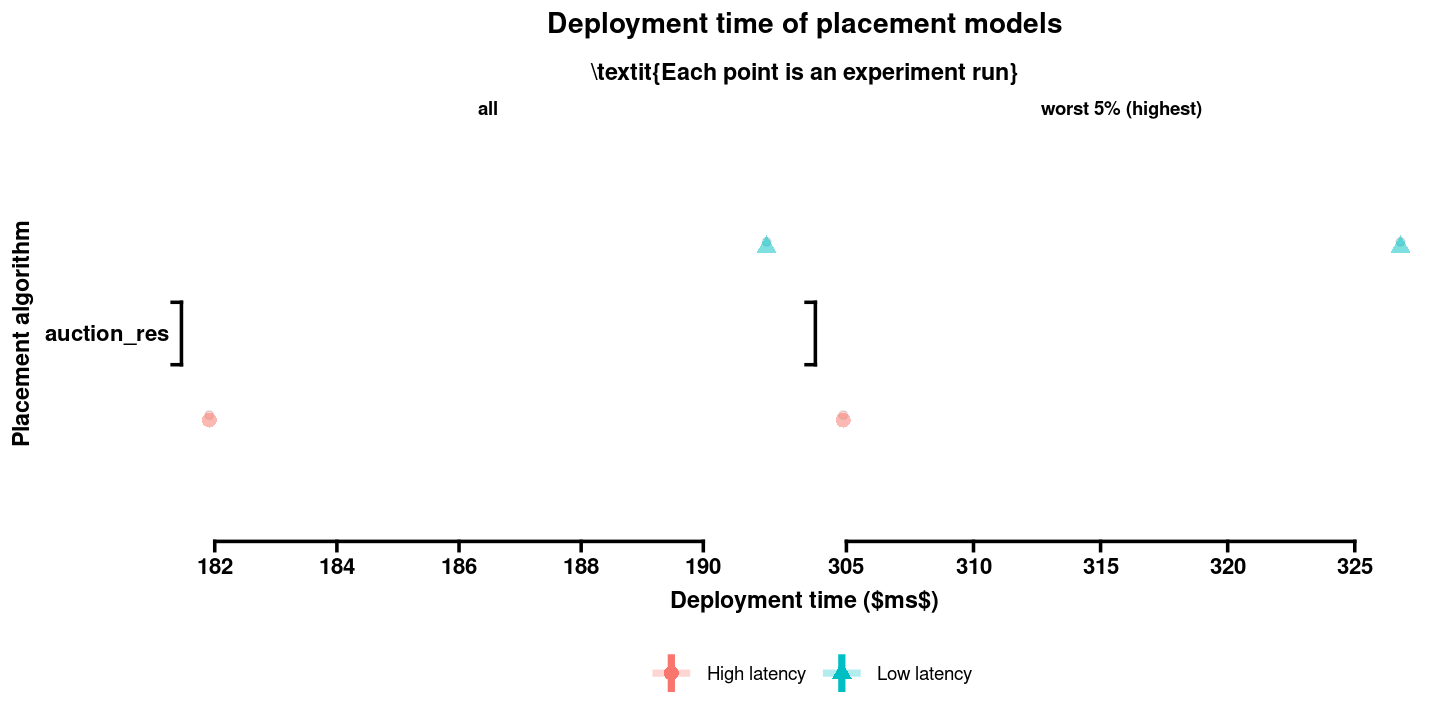

In [126]:
deployment_times <- deployment_times_raw %>%
  ungroup() %>%
  select(latency_type, sla_id, folder, metric_group, value, metric_group_group) %>%
  distinct() %>%
  drop_na()

top_1_percent <- deployment_times %>%
  group_by(folder, metric_group, metric_group_group, latency_type) %>%
  arrange(desc(value), .by_group = T) %>%
  mutate(rank = row_number()) %>%
  filter(rank <= ceiling(n() * 0.05)) %>%
  group_by(folder, metric_group, metric_group_group, latency_type) %>%
  summarize(avg_time_1_percent = mean(value))


deployment_times <- deployment_times %>%
  group_by(folder, metric_group, metric_group_group, latency_type) %>%
  summarize(avg_time = mean(value)) %>%
  inner_join(top_1_percent, by = c("folder", "metric_group", "metric_group_group", "latency_type")) %>%
  gather(key = "average_type", value = "average", avg_time, avg_time_1_percent) %>%
  mutate(average_type = case_when(
    average_type == "avg_time" ~ "all",
    average_type == "avg_time_1_percent" ~ "worst 5% (highest)",
  )) %>%
  {
    .
  }

deployment_times <- deployment_times %>%
  inner_join(total_low_latency, by = c("metric_group", "metric_group_group", "folder")) %>%
  mutate(ratio_low_latency_functions = paste0(round(ratio_low_latency_functions * 100, 0), "%"))


fig(12, 7)
deployment_times_all <- deployment_times %>%
  # filter(average_type == "all") %>%
  correct_names() %>%
  ggplot(
    aes(
      y = `Placement method`,
      x = average * 1000,
      color = latency_type,
      shape = latency_type,
      fill = latency_type,
      # group = `Placement method`
      # dotsize = 0.6,
      # bindwidth=0.5,
      # # group = average_type,
      # linewidth=0,
    )
  ) +
  stat_dotsinterval(slab_alpha =0.6, position = "dodge", binwidth = unit(2, "mm"), scale = 0.95, size = 10, slab_linewidth = 0) +
  gghighlight(metric_group == "auction", unhighlighted_params = list(slab_alpha = 0.3, point_alpha = 0.3, colour = NULL, fill = NULL, alpha = 0.3), label_params = list(linewidth = 10), calculate_per_facet = TRUE) +
  facet_grid2(cols = vars(average_type), scales = "free", axes = "all", remove_labels = "y") +
  labs(
    x = "Deployment time ($ms$)",
    y = "Placement algorithm",
    title = "Deployment time of placement models",
    subtitle = "\\textit{Each point is an experiment run}",
    color = "Function type",
    shape = "Function type",
    fill = "Function type",
  ) +
  theme(
    legend.position = "bottom",
    # legend.direction = "vertical",
  )+
  coord_capped_cart(bottom='both')+
  scale_y_discrete(guide = guide_prism_bracket(width = 0.15))
  fig(12, 6)
deployment_times_all


In [127]:
# nb_experiences_per_categories <- total_low_latency %>%
#     ungroup()  %>% 
#     select(folder, metric_group, ratio_low_latency_functions) %>% 
#     group_by(metric_group, ratio_low_latency_functions) %>% 
#     distinct() %>% 
#     count() %>%
#     mutate(ratio_low_latency_functions = paste0(round(ratio_low_latency_functions * 100, 0), "%")) %>%
#     pivot_wider(names_from = ratio_low_latency_functions, values_from = n) %>%
#     rowwise() %>%
#     mutate(total = sum(c_across(c(`25%`, `50%`, `75%`)))) %>%
#     ungroup() %>%
#     correct_names() %>%
#     select(-metric_group) %>%
#     select(`Placement method`, "25%", "50%", "75%", "total")

# nb_experiences_per_categories


In [128]:
escape_latex_special_chars <- function(text) {
  # Define special characters to escape
  special_chars <- c("%", "&", "#", "_", "\\$", "\\{", "\\}", "\\^", "\\~")
  
  # Escape each special character with a backslash
  for (char in special_chars) {
    text <- gsub(char, paste0("\\", substring(char, nchar(char), nchar(char))), text, fixed = TRUE)
  }
  
  return(text)
}


tibble_to_latex_tabular <- function(data, file) {
  cat("\\begin{tabular}{", paste0(rep("c", ncol(data)), collapse = " "), "}\n", file = file)
  cat("\\hline\n", file = file, append = TRUE)
  
  # Print column names with escaped special characters
  cat(paste0(escape_latex_special_chars(colnames(data)), collapse = " & "), " \\\\\n", file = file, append = TRUE)
  cat("\\hline\n", file = file, append = TRUE)
  
  # Print rows with escaped special characters
  for (i in 1:nrow(data)) {
    cat(paste0(escape_latex_special_chars(as.character(data[i, ])), collapse = " & "), " \\\\\n", file = file, append = TRUE)
  }
  
  cat("\\hline\n", file = file, append = TRUE)
  cat("\\end{tabular}", file = file, append = TRUE)
}


In [129]:
if (length(find.package('tikzDevice', quiet=TRUE))){
    library(tikzDevice)
    options(tikzDefaultEngine = "xetex")
    options(
    tikzSanitizeCharacters = c('%'),
    tikzReplacementCharacters = c('\\%'))

    tikzDevice::tikz("./nodes.tex", width=15, height=5, standAlone=FALSE, sanitize = TRUE) #, standAlone = TRUE)
    plot(net_connected, layout = coords,asp=0.22, margin=-0, edge.label = E(net_connected)$weight, edge.width = 1, vertex.size = 5, vertex.label.cex = 1, vertex.dist = 20, edge.arrow.size = 0.5, edge.label.cex = 0.8, edge.label.dist = 1.5)
    dev.off()

    tikzDevice::tikz("./deploymenttimes.tex", width=12, height=6, standAlone=FALSE, sanitize = TRUE) #, standAlone = TRUE)
    print(deployment_times_all)
    dev.off()

    tikzDevice::tikz("./apdex.tex", width=12, height=6, standAlone=FALSE, sanitize = TRUE) #, standAlone = TRUE)
    print(apdex_plot)
    dev.off()

    tikzDevice::tikz("./nb_bids.tex", width=12, height=6, standAlone=FALSE, sanitize = TRUE) #, standAlone = TRUE)
    print(bids_function_plot)
    dev.off()

    tikzDevice::tikz("./earnings.tex", width=12, height=4, standAlone=FALSE, sanitize = TRUE) #, standAlone = TRUE)
    print(transform_ratio_graph_plot_earnings)
    dev.off()

    tikzDevice::tikz("./jain.tex", width=9, height=4, standAlone=FALSE, sanitize = TRUE) #, standAlone = TRUE)
    print(transform_ratio_graph_plot_jain)
    dev.off()

    tikzDevice::tikz("./sum_earnings.tex", width=9, height=4, standAlone=FALSE, sanitize = TRUE) #, standAlone = TRUE)
    print(transform_ratio_graph_plot_sum_earnings)
    dev.off()

    output_file <- "nb_experiences_per_categories.tex"
    tibble_to_latex_tabular(nb_experiences_per_categories, output_file)
}